We will carry out a very simple experiment implementing a *pedagogical* (as opposed to decompositional or ecletic) approach to Rule Extraction from a Neural Network, with the goal of extracting an interpretation (via proxy) of the resulting trained Neural Network (NN).  
We choose this approach for two reasons:  
- It is architecture-agnostic, i.e. the Neural Network is treated like a black box and therefore could be a Multi-Layer Perceptron, a Convolutional Neural Network, or an entirely different classifier altogether. This makes this type of approach more general (compared to a decompositional one).
- It will likely have lower complexity and computational requirements than most decompositional approaches since its dimensionality, $d$, is the same as that of the target function's domain for classification into $C$ classes, $f: \mathbb{R}^d \rightarrow \{i, \ldots, C\}$, as opposed to decompositional approaches which seek $f: \mathbb{R}^{\mathrm{dim}(\mathbf{W_{l,\,ij}})} \rightarrow \{i, \ldots, C\}$ (where $\mathrm{dim}(\mathbf{W_{l,\,ij}})$ denotes the total number of weights and biases in the NN model).

In [1]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import numpy as np

For a test run load any default scikit-learn data set:  
(it is ridiculous to try to train a neural network on a data set this small, but it's just a toy example as food for thought.)

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
Y = iris.target

In [3]:
#import pickle

#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/X_standard_train.pkl', 'rb') as fb:
#    Xtrain = pickle.load(fb)

#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/X_standard_val.pkl', 'rb') as fb:
#    Xtest = pickle.load(fb)
    
#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/Ytrain.pkl', 'rb') as fb:
#    Ytrain = pickle.load(fb)
    
#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/Yval.pkl', 'rb') as fb:
#    Ytest = pickle.load(fb)
    

    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/X_standard_train.pkl', 'rb') as fb:
#    Xtrain = pickle.load(fb)

#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/X_standard_val.pkl', 'rb') as fb:
#    Xtest = pickle.load(fb)
    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/Ytrain.pkl', 'rb') as fb:
#    Ytrain = pickle.load(fb)
    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/Yval.pkl', 'rb') as fb:
#    Ytest = pickle.load(fb)
    
 
    
#X = np.concatenate((Xtrain, Xtest), axis=0)
#Y = np.concatenate((Ytrain, Ytest), axis=0)

Split the data set into training, validation, and test sets.  
We will not touch the test set at all.

def TrainValTestSplit(X, Y, fracs_list=[0.7, 0.2, 0.1], shuffle=True, seed=42):
    """Split the samples x features Numpy array, X, into training, validation, and test sets as
    specified in fractions in list fracs_list (e.g. [0.6, 0.2, 0.2])
    
    Return Numpy arrays:
    Xtrain, Ytrain, Xval, Yval, Xtest, Ytest"""
    
    assert X.shape[0] == Y.shape[0]
    
    assert sum(fracs_list) == 1.0
    
    trainfrac, valfrac, testfrac = fracs_list
    idxs = np.arange(X.shape[0])

    if shuffle==True:
        np.random.seed(seed)
        np.random.shuffle(idxs)
        np.random.seed(None) # Reset to the default value in case numpy uses the seed later (somewhere below)

    trainidx = idxs[:int(trainfrac*len(idxs))]
    validx = idxs[int(trainfrac*len(idxs)):int(trainfrac*len(idxs))+int(valfrac*len(idxs))]
    testidx = idxs[int(trainfrac*len(idxs))+int(valfrac*len(idxs)):]

    #Xtrain, Ytrain = X[trainidx], Y[trainidx]
    #Xval, Yval = X[validx], Y[validx]
    #Xtest, Ytest = X[testidx], Y[testidx]
    #return Xtrain, Ytrain, Xval, Yval, Xtest, Ytest
    return trainidx,validx,testidx

trainidx, validx, testidx = TrainValTestSplit(X, Y, fracs_list=[0.6, 0.2, 0.2])

Xtrain, Ytrain = X[trainidx], Y[trainidx]
Xval, Yval = X[validx], Y[validx]
#Xtest, Ytest = X[testidx], Y[testidx]

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xval = X[train_index], X[test_index]
    Ytrain, Yval = Y[train_index], Y[test_index]

TRAIN: [144 117 115  22  28  38  57 111  91 112  45  56  98  58   1   7 135  69
  80 119 131  96   4  31  93  82   5  63 137 143 140  83 126 132   8  10
  13  73  33  15 130  62 138  16  27  32  52  75  26  95  79  60 108  41
  76  77  87  71 148  11  74 146  84  66 128  94 118  48  59 125 106 124
 145  17 107  40  49 104  97  20  30  25  42  14  92 105 122 116  35 101
   2  18  70  64  72  53  43 114 133  29 127  78  34 120 141] TEST: [136 142  39  44  50  23  90 149  46  55  21 147  47 123  67 134  68  65
  51   0  54 103  24  81 129 102 113 100  89 110  99  19   6  88  86 121
  85  37   9  61  36 109   3  12 139]


The size of the training and validation sets, as well as the class labels and their distribution.

In [5]:
print(Xtrain.shape)
print(Xval.shape)

(105, 4)
(45, 4)


In [6]:
print(np.unique(Y))

[0 1 2]


In [7]:
print(np.bincount(Ytrain))

[35 35 35]


Choose scaling. Standard scaling, minmax scaling, whitening, etc.

In [8]:
# Perform data whitening (make covariance matrix the identity matrix to remove auto-correlations)
def whitening(X):
    Xcentred = X - np.mean(X, axis=0)
    cov = np.dot(Xcentred.T, Xcentred) / float(Xcentred.shape[0])
    U,S,V = np.linalg.svd(cov)
    Xrot = np.dot(Xcentred,U)
    # Xrot_reduced = np.dot(Xcentred, U[:,:100])
    Xwhite = Xrot / np.sqrt(S + 1e-5)
    return Xwhite

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)

scaler_train = scaler.fit(Xtrain)
Xtrain = scaler_train.transform(Xtrain)

#scaler_val = scaler.fit(Xval)
Xval = scaler_train.transform(Xval)

#Xtrain = scaler.fit_transform(Xtrain)
#Xval = scaler.fit_transform(Xval)

Check for missing values. Impute if values are missing.

In [10]:
def fancyImpute(X_incomplete):
    """Imputation methods. Options: SimpleFill, DenseKNN, SoftImpute,
    IterativeSVD, MICE (ordinal variables only), MatrixFactorization,
    NuclearNormMinimization (too slow for large matrices)."""
    
    import fancyimpute as fi
    #from fancyimpute import (NuclearNormMinimization, BiScaler, DenseKNN)

    # rescale both rows and columns to have zero mean and unit variance
    biscaler = fi.BiScaler()
    X_incomplete_normalized = biscaler.fit_transform(X_incomplete)

    # use 3 nearest rows which have a feature to fill in each row's missing features
    #solver = fi.DenseKNN(k=3)
    solver = fi.SoftImpute()
    # Options for solver = NuclearNormMinimization
    X_filled_normalized = solver.complete(X_incomplete_normalized)
    X_filled = biscaler.inverse_transform(X_filled_normalized)

    #mse = ((X_filled[missing_mask] - X[missing_mask]) ** 2).mean()
    #print("MSE of reconstruction: %f" % mse)
    return X_filled

In [11]:
print(float(Xtrain[np.isnan(Xtrain)].shape[0])/Xtrain.shape[0])
print(float(Xval[np.isnan(Xval)].shape[0])/Xval.shape[0])

0.0
0.0


In [12]:
if Xtrain.any() == np.nan:
    Xtrain = fancyImpute(Xtrain)
if Xval.any() == np.nan:
    Xval = fancyImpute(Xval)

In [13]:
Ytrain = Ytrain.reshape((Ytrain.shape[0], 1))
print(Ytrain.shape)
Yval = Yval.reshape((Yval.shape[0], 1))
print(Yval.shape)

(105, 1)
(45, 1)


Build the Multi-Layer Perceptron

In [14]:
import theano
from theano import tensor as T
#from theano.printing import debugprint

#theano.config.compute_test_value = 'warn' # default is 'off'
theano.config.compute_test_value = 'off'
#print theano.config.optimizer # default value is 'fast_run'
#print theano.config.exception_verbosity # default value is 'low'

import LasagneUpdateRules_Jan_2016 as lur

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)


In [15]:
print(theano.__version__) # T.nnet.relu() activation function available only from Theano 0.7.1 onwards

0.9.0dev2.dev-58e93f9b94113d39fab7da6aefaf354cddead2e1


In [16]:
def floatX(array):
    """Convert array to Numpy array of a type supported by the CPU or GPU, accordingly"""
    return np.asarray(array, dtype=theano.config.floatX)

def init_weights(shape, frac=0.01):
    """Initialize weights randomly. Reduce weight size by factor to keep them closer to zero where gradient is largest
    and the learning is fastest at the beginning.
    This is Glorot initialisation, with a scaling factor."""
    #return theano.shared(floatX(frac*np.random.uniform(low=0.0, high=1.0, size=shape), borrow=True)
    #return theano.shared(floatX(np.sqrt(2/(shape[0]*shape[1]))*np.random.normal(loc=0, scale=1, size=shape)), borrow=True)
    return theano.shared(floatX(np.sqrt(2)*np.random.normal(loc=0, scale=1, size=shape)), borrow=True)

def init_bias(shape):
    """Initialize bias to array of zeros"""
    return theano.shared(value=np.zeros(shape, dtype=theano.config.floatX), borrow=True)

def init_ortho(shape):
    """Initialize weights to an orthogonal matrix. Output matrix is square,
    output matrix will only be of the requested dimensions if square"""
    #W = np.random.randn(*shape)
    W = np.random.normal(loc=0, scale=1, size=shape)
    u, s, v = np.linalg.svd(W)
    #return theano.shared(value=np.sqrt(2).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)
    #return theano.shared(value=np.sqrt(2/(shape[0]*shape[1])).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)
    return theano.shared(value=np.sqrt(2).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)


#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
#from theano.sandbox.cuda.rng_curand import CURAND_RandomStreams as RandomStreams

def dropout(state_before, p=0.5):
    """Retain a fraction p of weights and set the other 1-p to zero"""
    #trng = T.shared_randomstreams.RandomStreams(np.random.randint(1000000, size=1))
    #trng = RandomStreams()
    trng = T.shared_randomstreams.RandomStreams()
    proj = T.cast((state_before * trng.binomial(state_before.shape, p=p, n=1, dtype=state_before.dtype))/p, theano.config.floatX)
    return proj

def to_onehot(array_column, n_classes=None):
    """Converts column array of integer labels (starting from 0) into
    one-hot encoding"""
    #array_column = np.asarray(array_column).flatten()
    if not np.equal(np.mod(array_column.any(), 1), 0):
        print("Problem: labels are not integers")
    if n_classes == None:
        # If no. of classes not given, deduce from data.
        # Can fail if not all possible classes found in vector.
        n_classes = len(np.unique(array_column))
    onehotcol = np.zeros((array_column.shape[0], n_classes))
    xmin = array_column.min()
    if np.equal(np.mod(array_column.all(), 1), 0) and xmin!=0:
        print("Labels don't start from 0, shifted them")
        array_column_shifted = array_column-xmin
        #print(array_column_shifted)
        for i in range(array_column_shifted.shape[0]):
            #print(i, array_column_shifted[i])
            onehotcol[i, int(array_column_shifted[i])] = 1
    else:
        for i in range(array_column.shape[0]):
            onehotcol[i, int(array_column[i])] = 1
    return onehotcol

import pickle, os

def save_model(parameters, filename):
    """Serialise Theano shared variables to disk"""
    dirname = 'saved_model'
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(os.path.join(dirname, filename+'.pkl'), 'wb') as fb:
        for p in parameters:
            pickle.dump(p.get_value(borrow=True),fb, -1)

Convert to 1-of-N representation for N > 2 class classification.

In [17]:
Ytrain = to_onehot(Ytrain)

Convert to GPU-friendly single precision floats

In [18]:
Xtrain = floatX(Xtrain)
Ytrain = floatX(Ytrain)

Xval = floatX(Xval)
Yval = floatX(Yval)

Convert data to theano shared variable type to make optimal usage of GPU memory.

In [19]:
Xtraintheano = theano.shared(Xtrain, borrow=True)
Ytraintheano = theano.shared(Ytrain, borrow=True)

Find greatest common divisor between training and validation sets, to use as batchsize to ensure prediction on full validation set. If this is not important, override batch size manually below.

In [20]:
from fractions import gcd

batchsize = gcd(Xtrain.shape[0], Xval.shape[0])

print(batchsize)

15


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  app.launch_new_instance()


In [21]:
batchsize = 1

In [22]:
nfeats = Xtrain.shape[1]
widhidlay = nfeats # To ensure autoencoder input and output have the same dimensions, as they must.

Build and train the Stacked Denoising Auto-encoders for unsupervised pre-training of the lower (non-output) layers of the neural network.

In [23]:
X = T.matrix(name='X')
Y = T.matrix(name='Y')
index = T.lscalar()

def pretrain_model(X, w_h1_pre, b_h1_pre, b_h2_pre):
    X = dropout(X, p=0.5)
    h1 = T.nnet.sigmoid(T.dot(X,w_h1_pre) + b_h1_pre)
    h2 = T.nnet.sigmoid(T.dot(h1,w_h1_pre.T) + b_h2_pre)
    return h2

n_pretrain_batches = int(Xtraintheano.get_value(borrow=True).shape[0] / batchsize)



n_epochs_pretrain = 10

In [24]:
w_h1_pre = init_weights((nfeats, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))

Xpred = pretrain_model(X, w_h1_pre, b_h1_pre, b_h2_pre)

cost = T.mean(T.sqr(Xpred-X))

params = [w_h1_pre, b_h1_pre, b_h2_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
#updates = lur.adam(cost,params,learning_rate=0.001)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain1 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain1(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output1 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano1 = theano.shared(floatX(ae_output1), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [25]:
print(ae_outputtheano1.get_value())

[[-1.19103551  1.41779578  1.37309361  1.32698011]
 [ 0.80892593  2.41460443 -1.11243331 -0.1369514 ]
 [ 1.8790822   0.15615433 -1.97928727 -1.34698796]
 [ 2.64585924  1.04846764  1.26534843  0.45406529]]


In [26]:
w_h1_pre = init_ortho((widhidlay, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))
b_h3_pre = init_bias((batchsize, widhidlay))


def pretrain_model(X, previous_weights, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre):
    h1 = T.nnet.sigmoid(T.dot(X,previous_weights) + b_h1_pre)
    h1 = dropout(h1, p=0.5)
    h2 = T.nnet.sigmoid(T.dot(h1,w_h1_pre) + b_h2_pre)
    h3 = T.nnet.sigmoid(T.dot(h2,w_h1_pre.T) + b_h3_pre)
    return h3

Xpred = pretrain_model(X, ae_outputtheano1, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre)

cost = T.mean(T.sqr(Xpred-X))

params = [w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
#updates = lur.adam(cost,params,learning_rate=0.001)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain2 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain2(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output2 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano2 = theano.shared(floatX(ae_output2), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [27]:
print(ae_outputtheano2.get_value())

[[ 0.58030272  0.38480541 -0.7973997  -0.96210188]
 [-0.46734151  0.62129545 -0.92144555  0.73567516]
 [-1.20928681  0.00150823 -0.026431   -0.78470397]
 [-0.06939504 -1.20138264 -0.77888864  0.04176965]]


In [28]:
w_h1_pre = init_ortho((widhidlay, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))
b_h3_pre = init_bias((batchsize, widhidlay))
b_h4_pre = init_bias((batchsize, widhidlay))


def pretrain_model(X, previous_weights1, previous_weights2, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre):
    h1 = T.nnet.sigmoid(T.dot(X,previous_weights1) + b_h1_pre)
    h2 = T.nnet.sigmoid(T.dot(h1,previous_weights2) + b_h2_pre)
    h2 = dropout(h2, p=0.5)
    h3 = T.nnet.sigmoid(T.dot(h2,w_h1_pre) + b_h3_pre)
    h4 = T.nnet.sigmoid(T.dot(h3,w_h1_pre.T) + b_h4_pre)
    return h4

Xpred = pretrain_model(X, ae_outputtheano1, ae_outputtheano2, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre)

cost = T.mean(T.sqr(Xpred-X))

params = [w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
#updates = lur.adam(cost,params,learning_rate=0.001)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain3 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain3(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output3 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano3 = theano.shared(floatX(ae_output3), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [29]:
print(ae_outputtheano3.get_value())

[[-0.40798014  1.05344474  0.37689537  0.68021011]
 [-0.7235465  -0.59474385  1.05716288 -0.15606034]
 [ 1.07795286  0.2073001   0.77092546 -0.27867204]
 [-0.40053925  0.64302665 -0.06605292 -1.20415831]]


Build the neural network itself.

In [30]:
#X = T.matrix(name='X')
#Y = T.matrix(name='Y')
#index = T.lscalar()

dropout_p = 0.5
relu_alpha = 0.

def model_train(X,w_h1,b_h1,w_h2,b_h2,w_h3,b_h3,w_o,b_o):
    h1 = T.nnet.relu(T.dot(X,w_h1) + b_h1, alpha=relu_alpha)
    #h1 = T.nnet.sigmoid(T.dot(X,w_h1) + b_h1)
    h1 = dropout(h1, p=dropout_p)
    h2 = T.nnet.relu(T.dot(h1,w_h2) + b_h2, alpha=relu_alpha)
    #h2 = T.nnet.sigmoid(T.dot(h1,w_h2) + b_h2)
    h2 = dropout(h2, p=dropout_p)
    h3 = T.nnet.relu(T.dot(h2,w_h3) + b_h3, alpha=relu_alpha)
    #h3 = T.nnet.sigmoid(T.dot(h2,w_h3) + b_h3)
    #h3 = dropout(h3, p=dropout_p)
    o = T.nnet.softmax(T.dot(h3,w_o) + b_o)
    #o = T.nnet.sigmoid(T.dot(h3,w_o) + b_o)
    return o

def model_test(X,w_h1,b_h1,w_h2,b_h2,w_h3,b_h3,w_o,b_o):
    h1 = T.nnet.relu(T.dot(X,w_h1) + b_h1, alpha=relu_alpha)
    #h1 = T.nnet.sigmoid(T.dot(X,w_h1) + b_h1)
    #h1 = dropout(h1, p=dropout_p)
    h2 = T.nnet.relu(T.dot(h1,w_h2) + b_h2, alpha=relu_alpha)
    #h2 = T.nnet.sigmoid(T.dot(h1,w_h2) + b_h2)
    #h2 = dropout(h2, p=dropout_p)
    h3 = T.nnet.relu(T.dot(h2,w_h3) + b_h3, alpha=relu_alpha)
    #h3 = T.nnet.sigmoid(T.dot(h2,w_h3) + b_h3)
    #h3 = dropout(h3, p=dropout_p)
    o = T.nnet.softmax(T.dot(h3,w_o) + b_o)
    #o = T.nnet.sigmoid(T.dot(h3,w_o) + b_o)
    return o


nfeats = Xtrain.shape[1]
widhidlay = nfeats
nclasses = 3
#nclasses = len(np.unique(Ytrain))  # Use 1 for binary classification or regression

# 3 hidden layers, initialise the weights and biases
#w_h1 = init_weights((nfeats, widhidlay))
w_h1 = ae_outputtheano1
b_h1 = init_bias((batchsize, widhidlay))
#w_h2 = init_ortho((widhidlay, widhidlay))
w_h2 = ae_outputtheano2
b_h2 = init_bias((batchsize, widhidlay))
#w_h3 = init_ortho((widhidlay, widhidlay))
w_h3 = ae_outputtheano3
b_h3 = init_bias((batchsize, widhidlay))
w_o = init_weights((widhidlay, nclasses))
b_o = init_bias((batchsize, nclasses))

# Runs the NN and outputs the result from its output node
yprobs_train = model_train(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)
yprobs_test = model_test(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)


# Predicted label is 1 if its probability is >=0.5, and 0 otherwise.
#ypred = (yprobs >= 0.5)

#ypred = T.switch(T.lt(yprobs, 0.5), 0, 1)

ypred_train = T.argmax(yprobs_train)
ypred_test = T.argmax(yprobs_test)


#err = T.mean(T.neq(ypred, Y))

params = [w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o]


#L1 = T.sum(T.abs_(w_h2)) + T.sum(T.abs_(w_h3)) 
#L2 = T.sum(T.sqr(w_h2)) + T.sum(T.sqr(w_h3)) 

L1 = T.sum(T.abs_(w_h2)) + T.sum(T.abs_(w_h3)) + T.sum(T.abs_(w_h1)) + T.sum(T.abs_(w_o))
L2 = T.sum(T.sqr(w_h2)) + T.sum(T.sqr(w_h3)) + T.sum(T.sqr(w_h1)) + T.sum(T.sqr(w_o))

    
cost = T.mean(T.nnet.categorical_crossentropy(yprobs_train, Y)) + 0.01*L1 + 0.01*L2
#cost = T.mean(T.nnet.binary_crossentropy(yprobs, Y)) + 0.001*L1 + 0.001*L2
#cost = T.mean(T.nnet.binary_crossentropy(yprobs, Y)) + 0.01*L2
#cost = T.mean(T.sqr(ypred-Y))
#cost = T.mean(T.sqr(yprobs-Y))

#updates = lur.sgd(cost,params,learning_rate=0.001)
updates = lur.adagrad(cost, params, learning_rate=0.01)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
#updates = lur.adam(cost,params,learning_rate=0.01)
#updates = lur.adamax(cost,params,learning_rate=0.01)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.01)




train = theano.function(
        inputs=[index],
        outputs=cost,
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize],
            Y: Ytraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


Xvaltheano = theano.shared(Xval, borrow=True)
Yvaltheano = theano.shared(Yval, borrow=True)

predict = theano.function(
        inputs=[index],
        #outputs=yprobs,
        #outputs=(yprobs,ypred),
        #outputs=(cost,yprobs,err),
        outputs=ypred_test,
        allow_input_downcast=True,
        givens={
            X: Xvaltheano[index * batchsize : (index + 1) * batchsize]
        }
    )


Train the neural network.

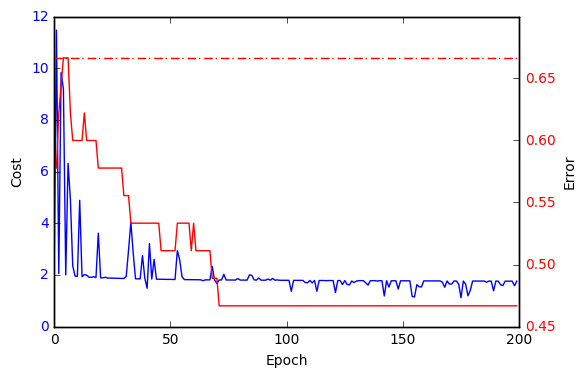

Training took 37.3 seconds.


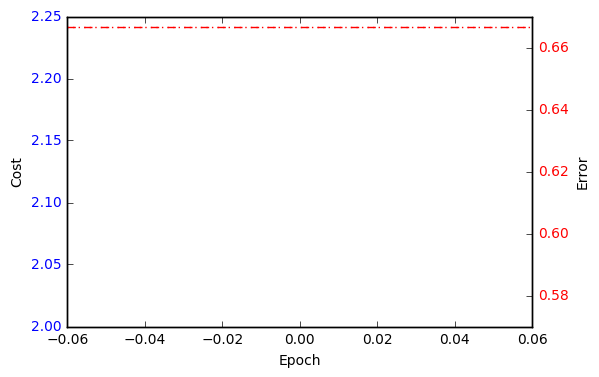

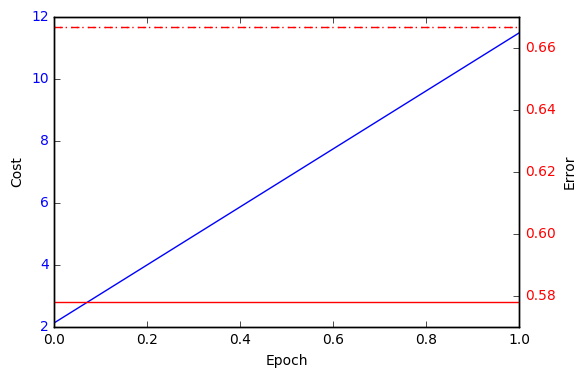

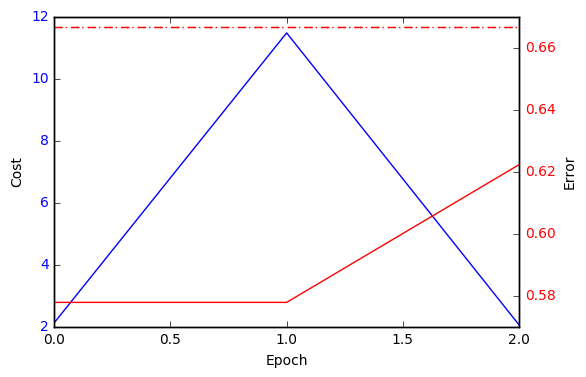

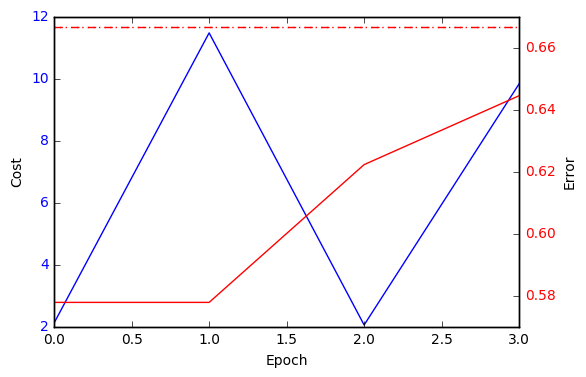

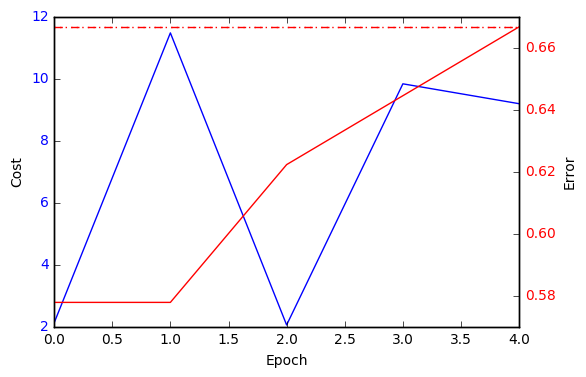

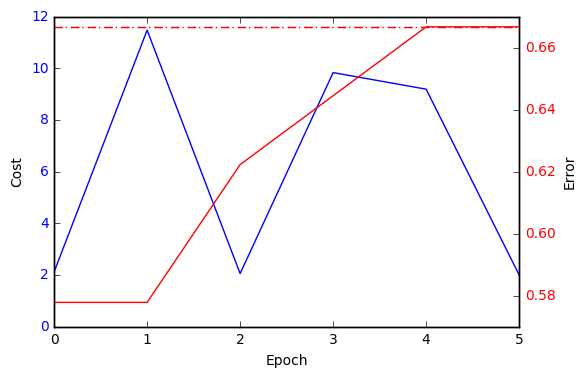

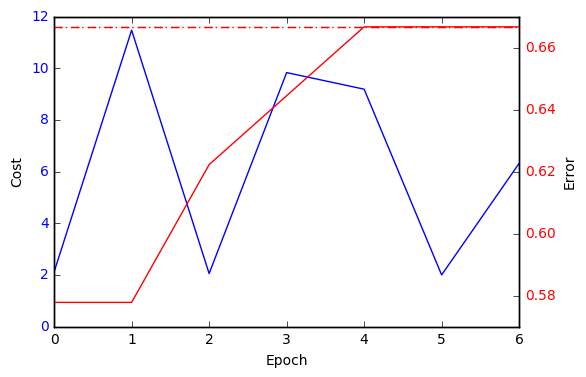

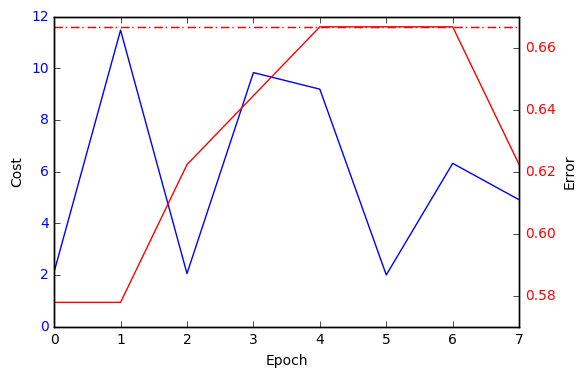

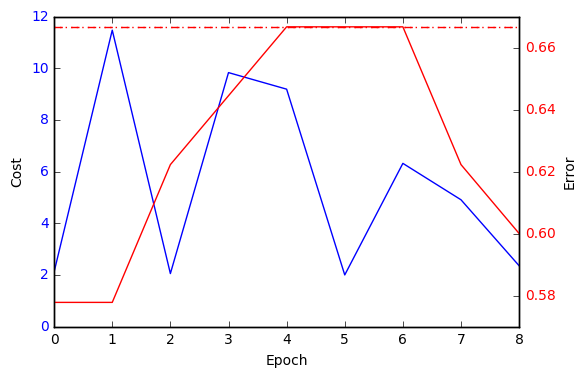

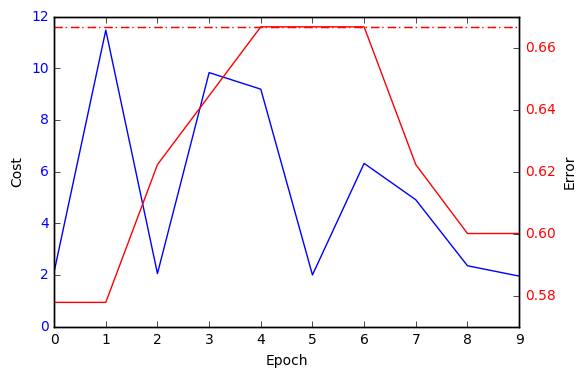

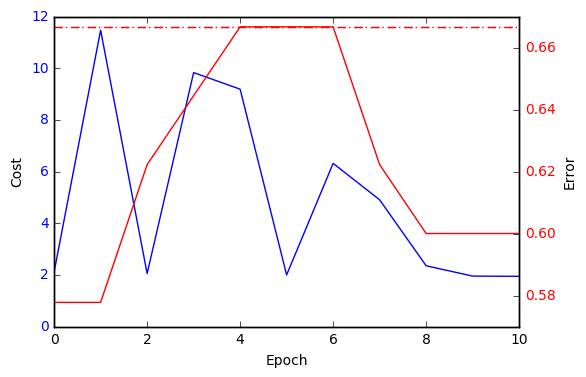

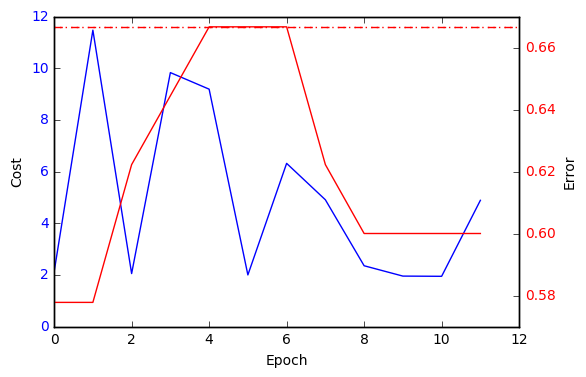

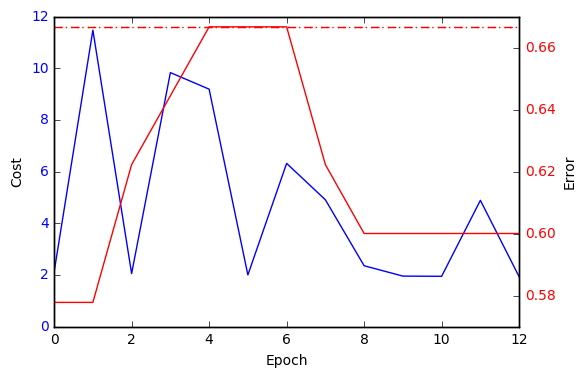

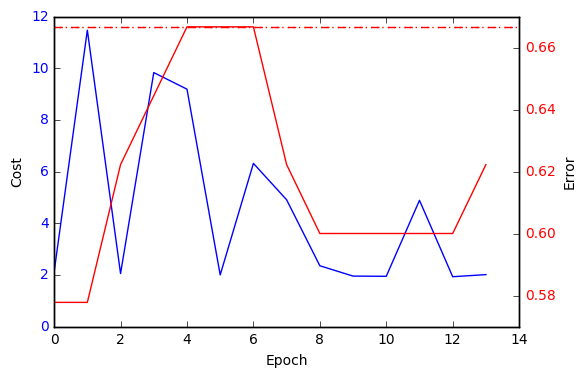

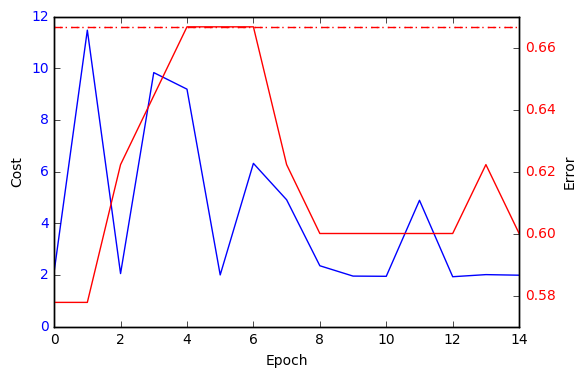

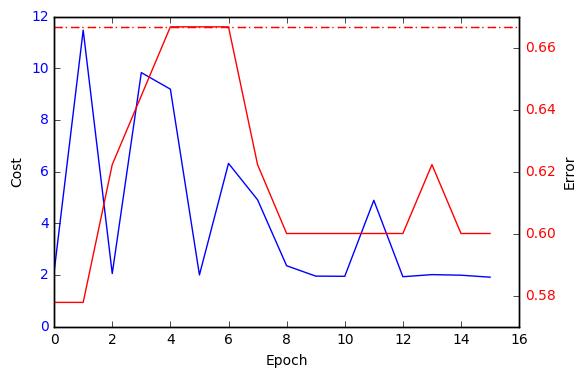

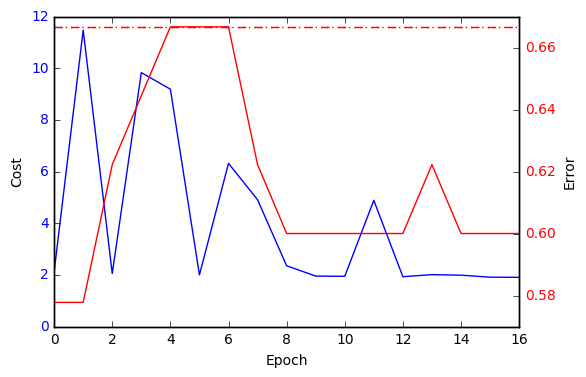

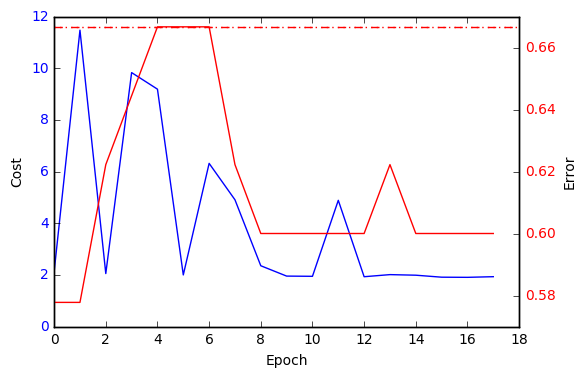

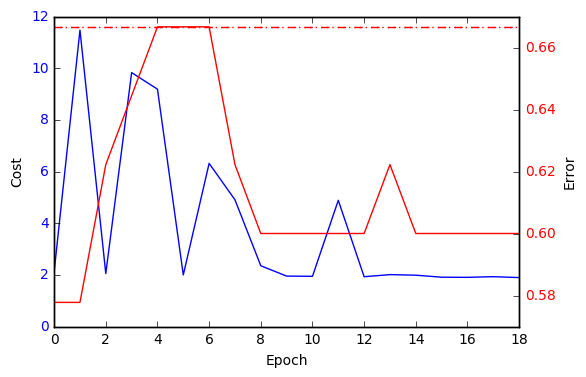

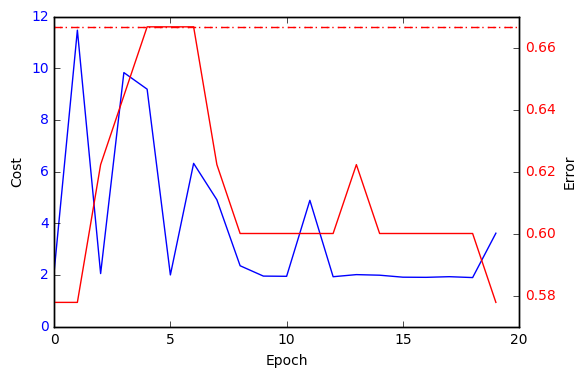

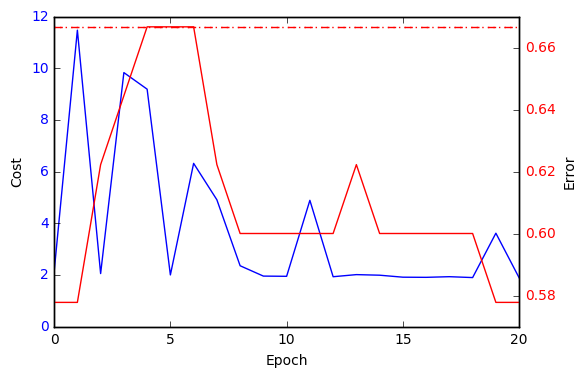

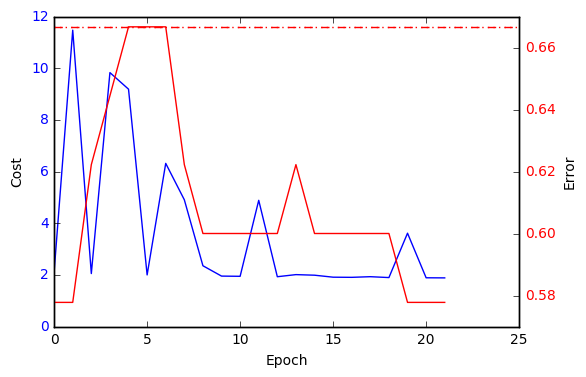

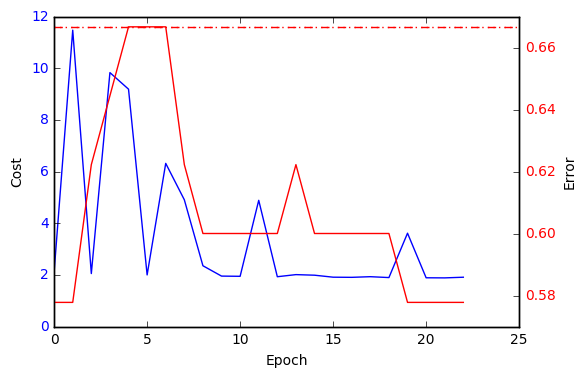

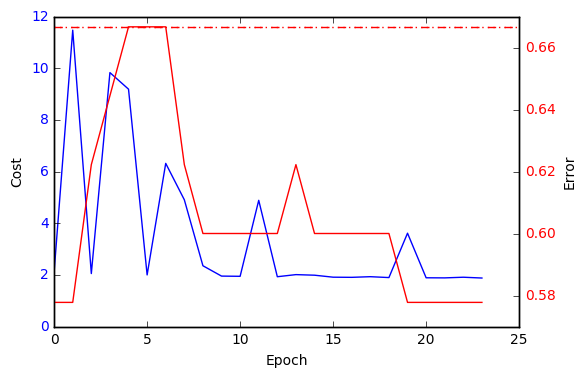

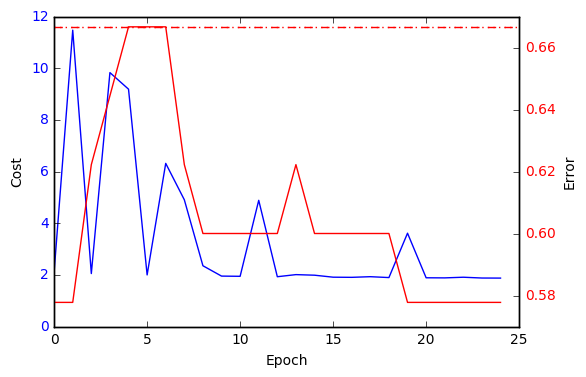

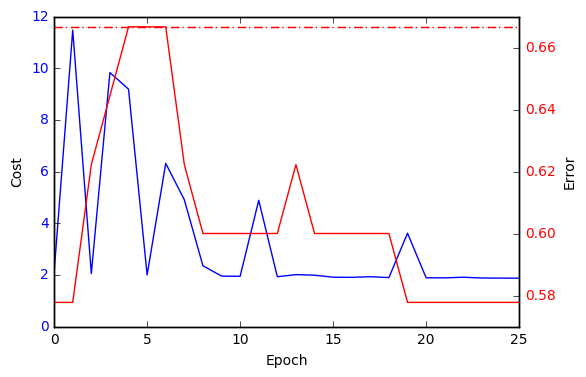

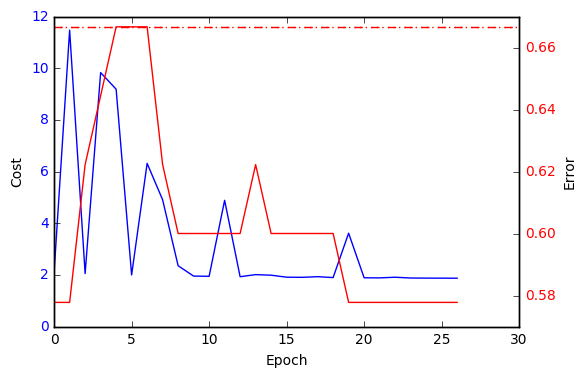

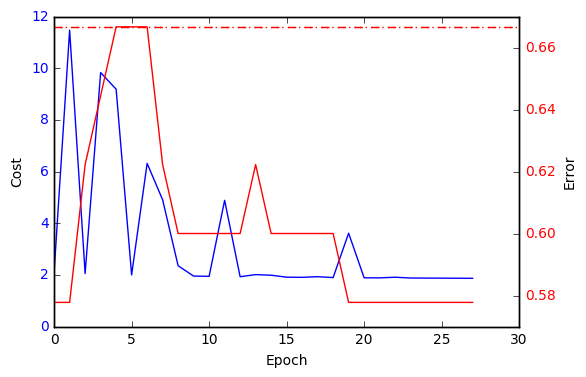

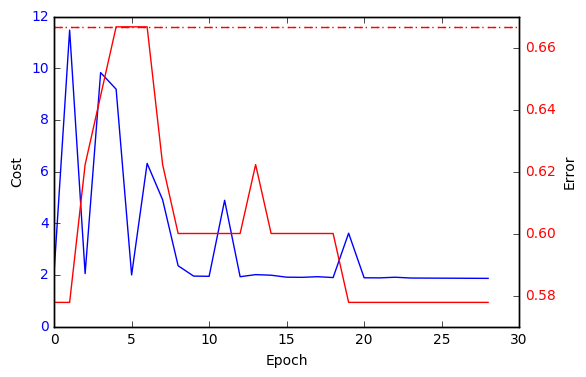

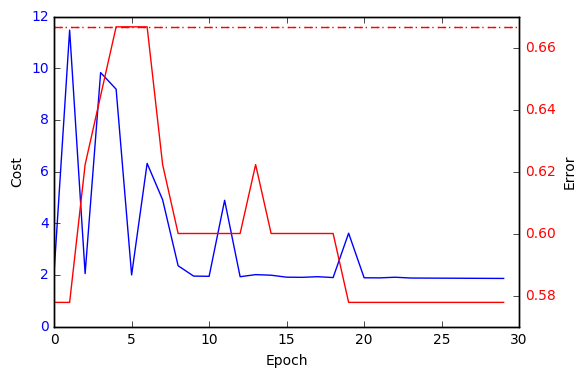

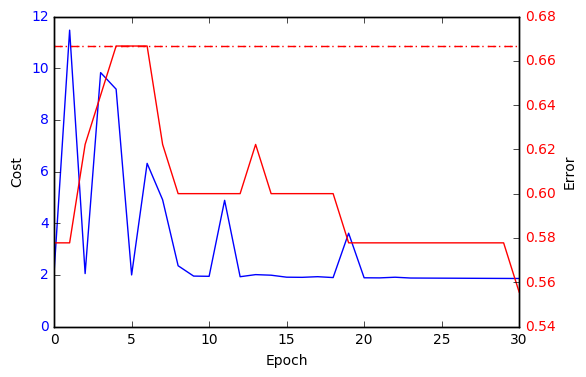

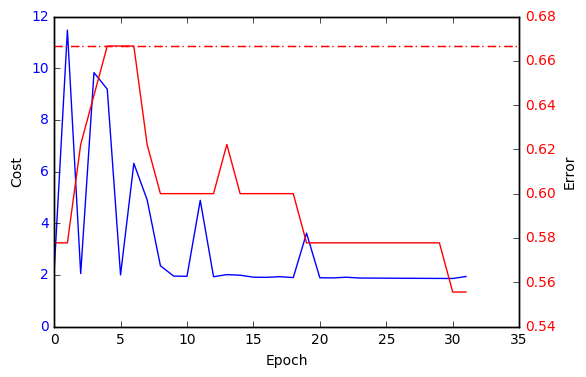

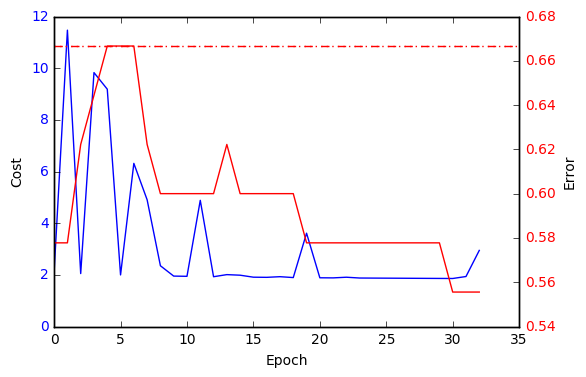

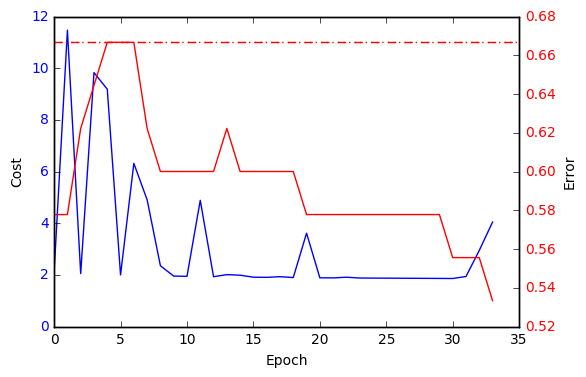

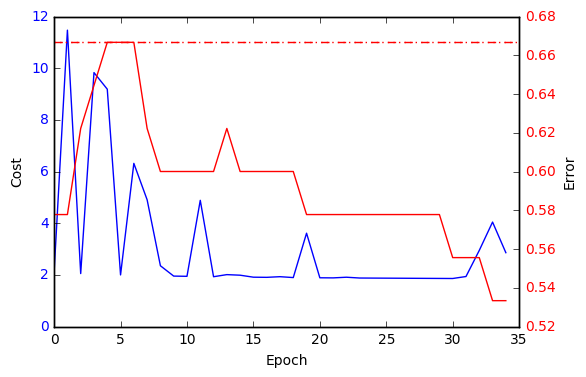

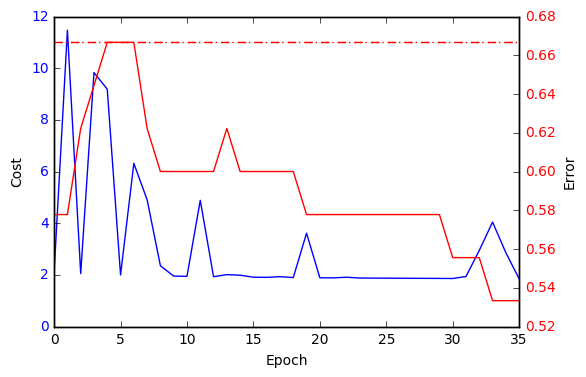

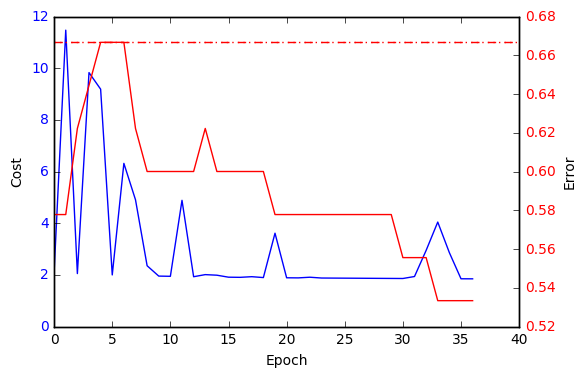

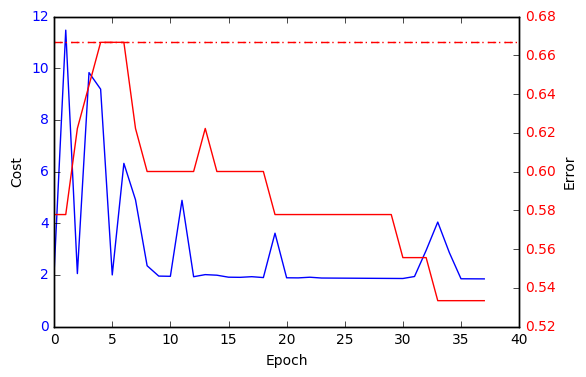

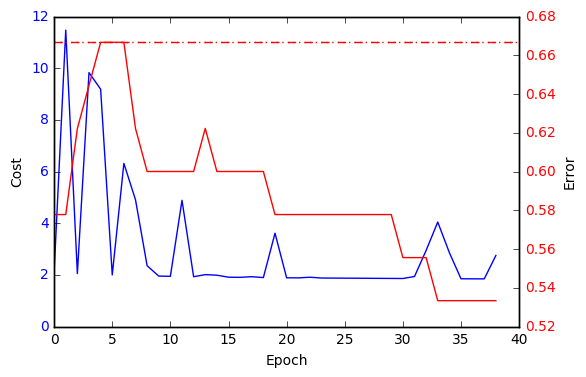

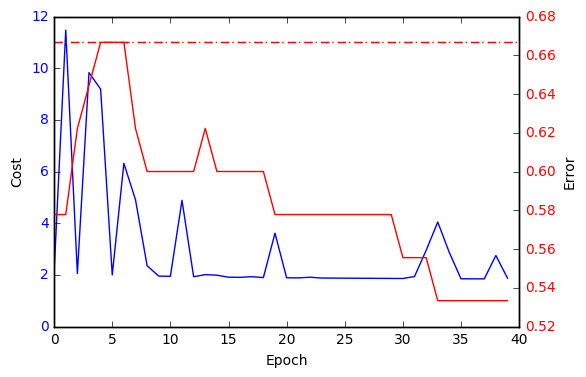

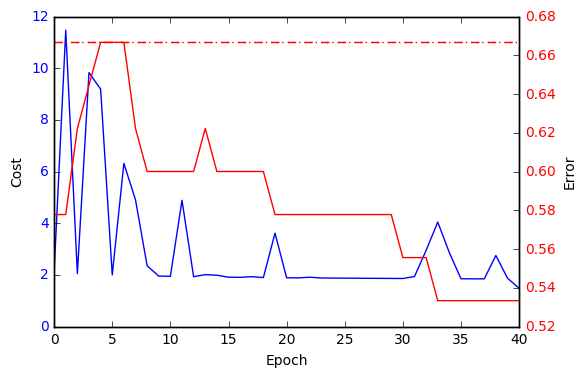

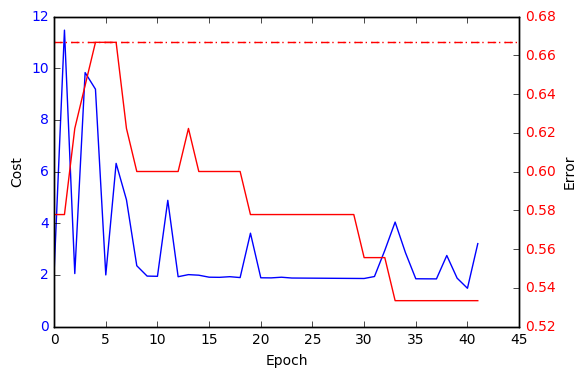

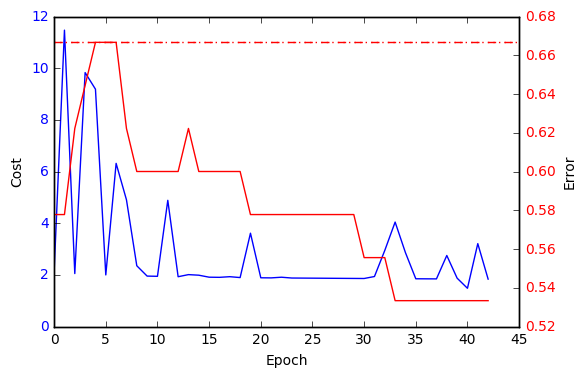

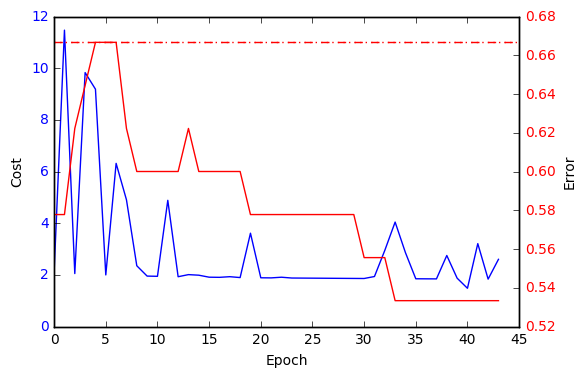

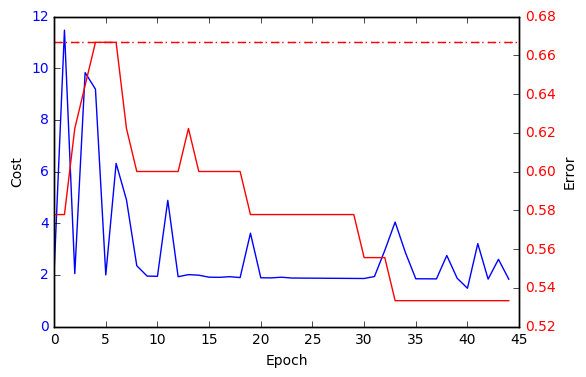

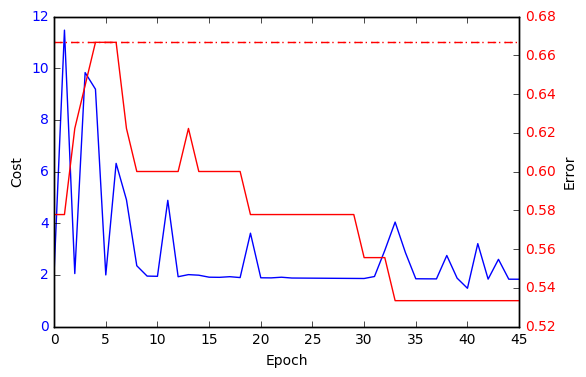

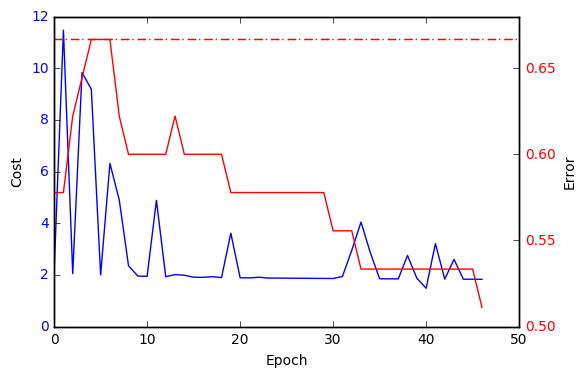

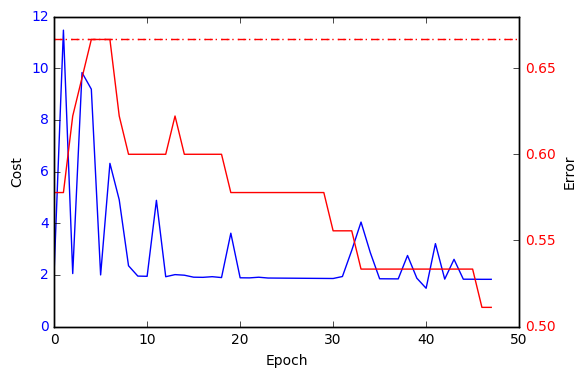

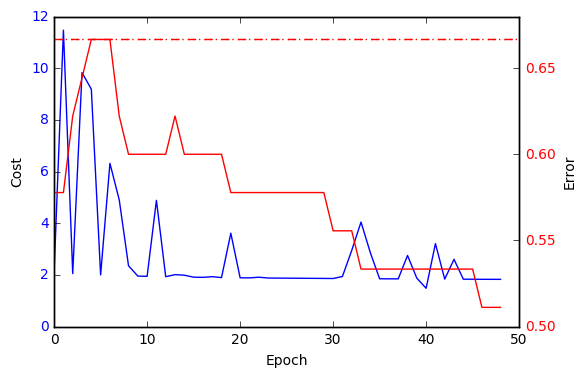

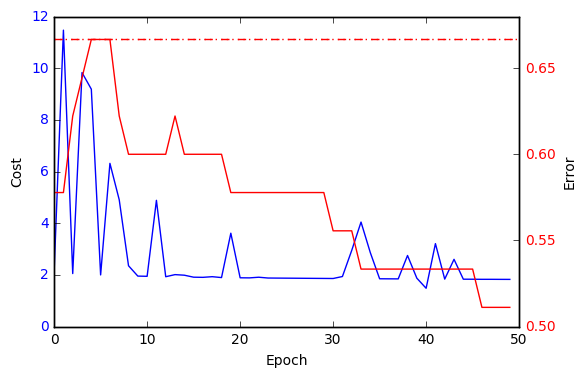

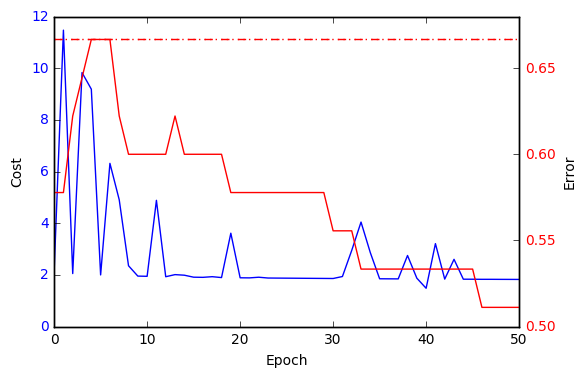

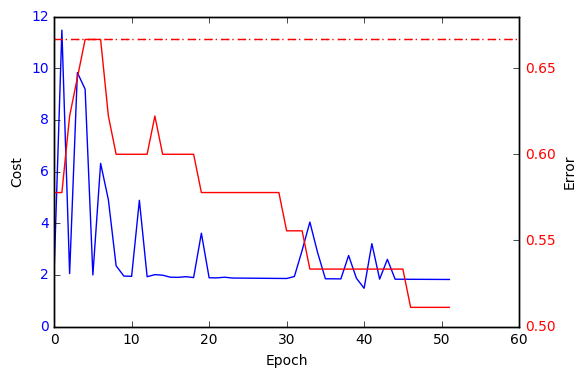

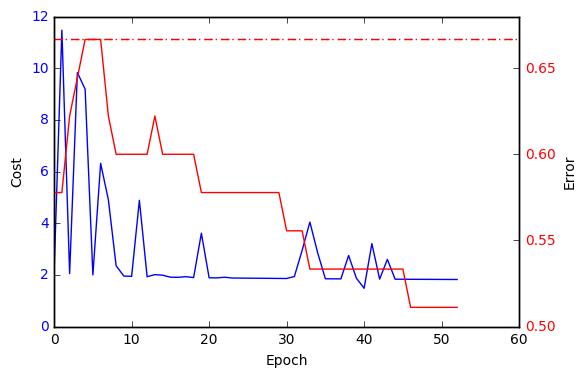

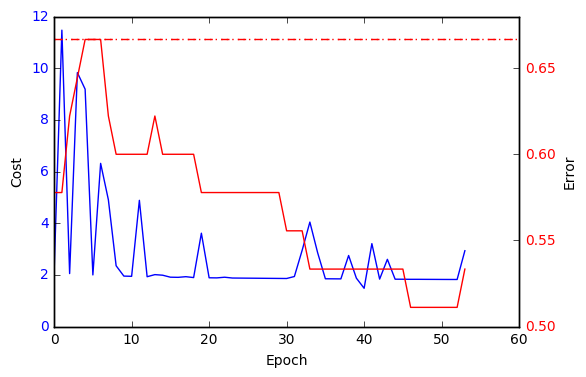

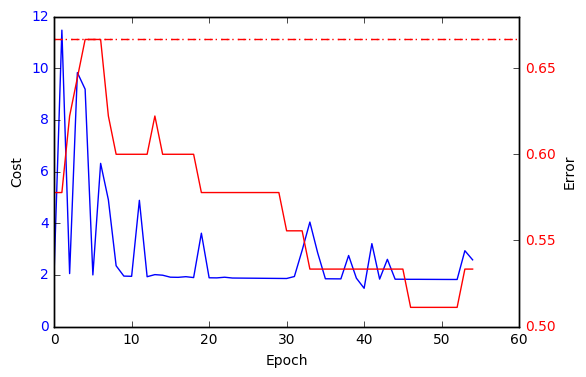

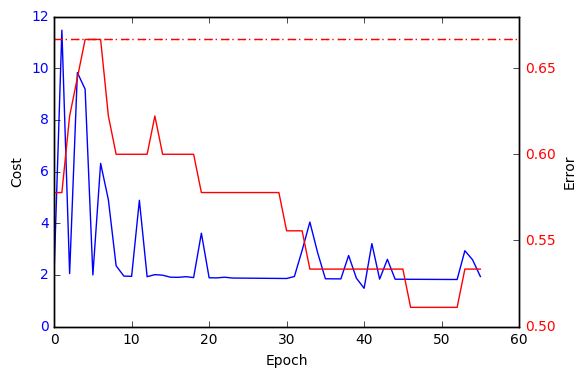

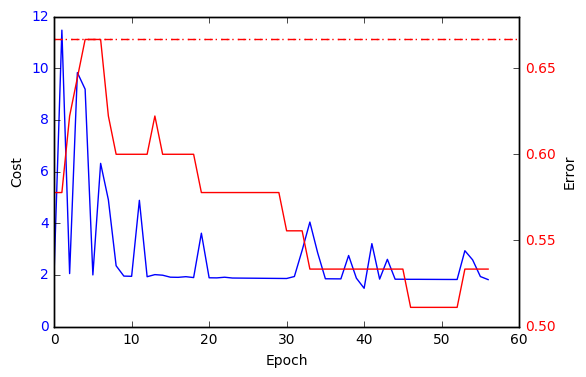

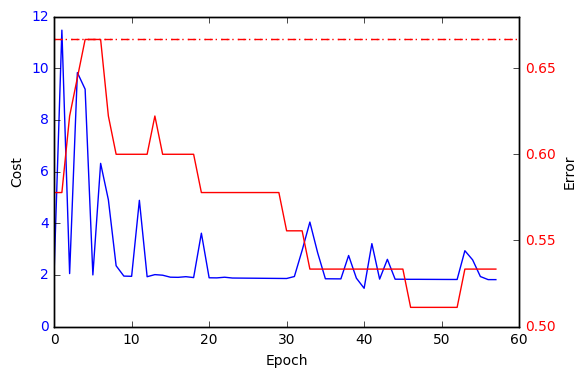

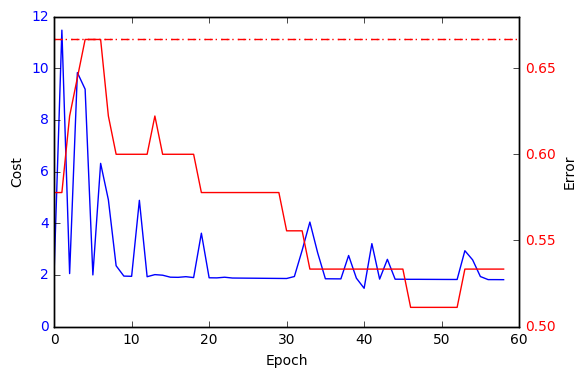

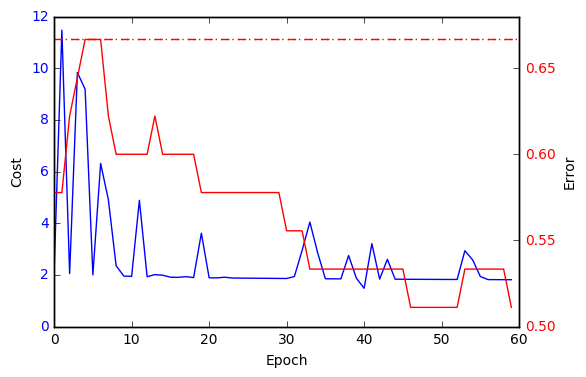

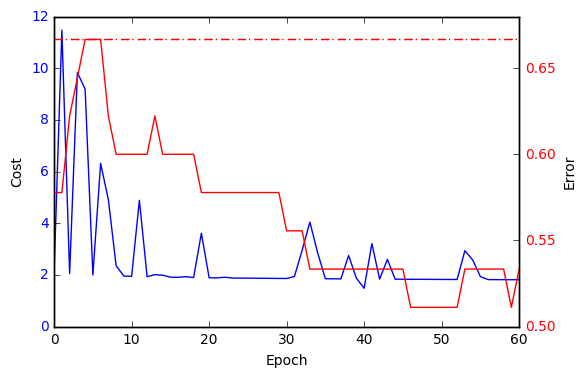

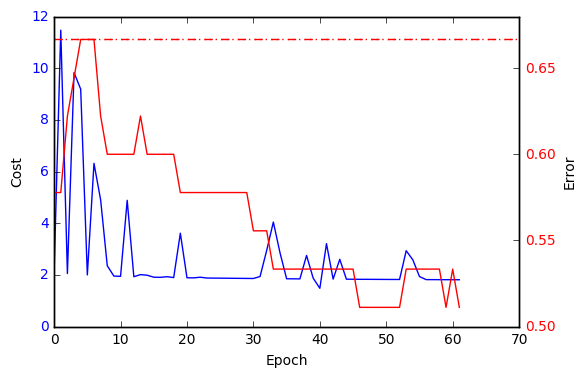

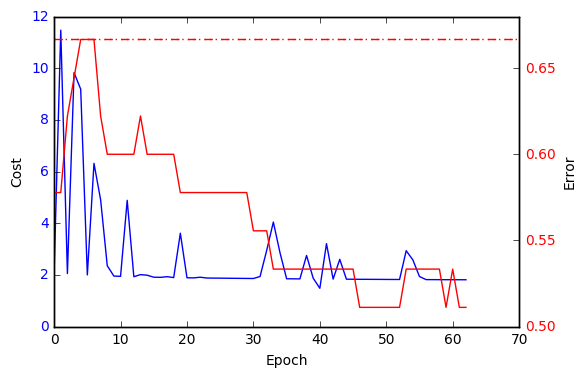

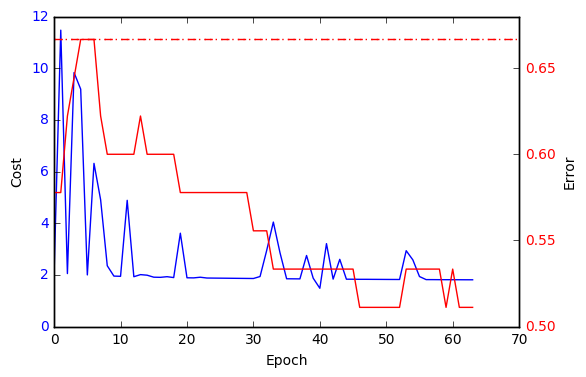

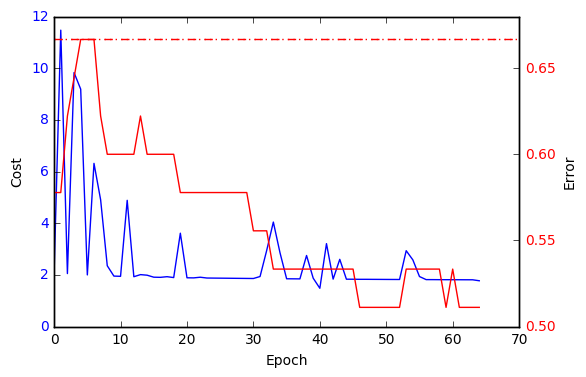

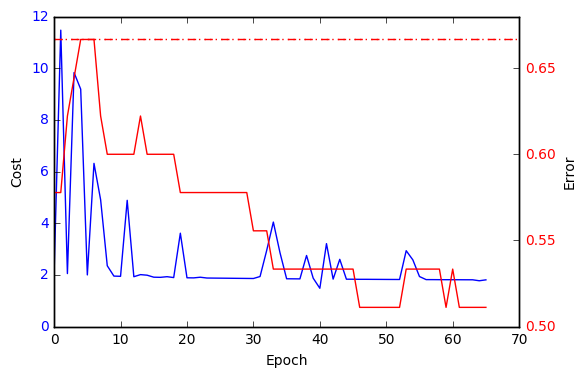

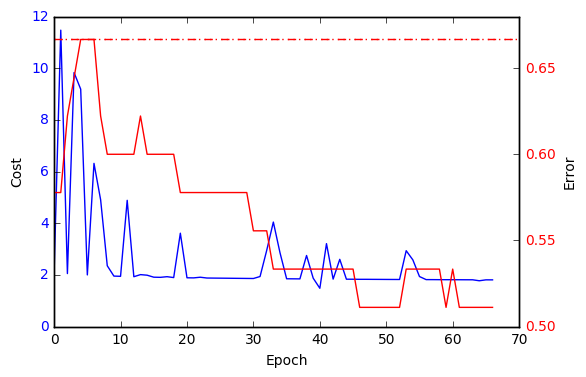

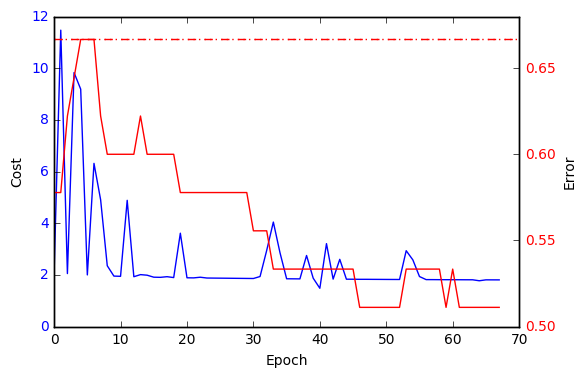

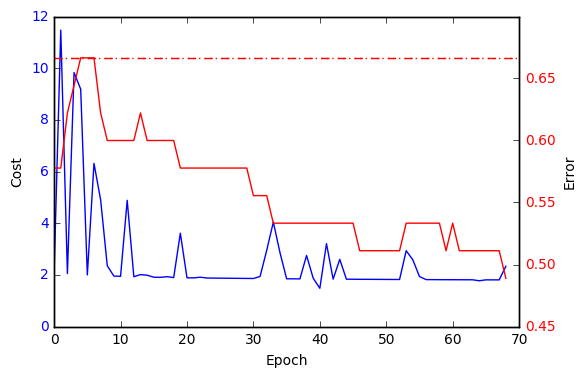

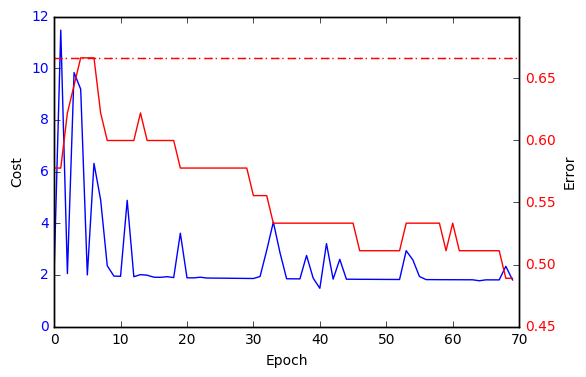

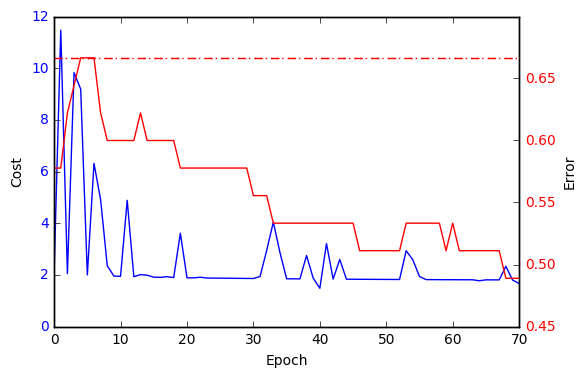

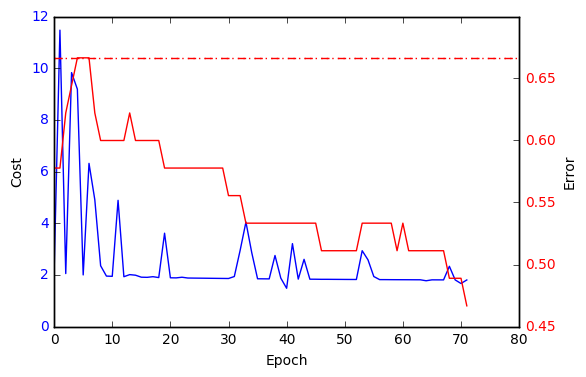

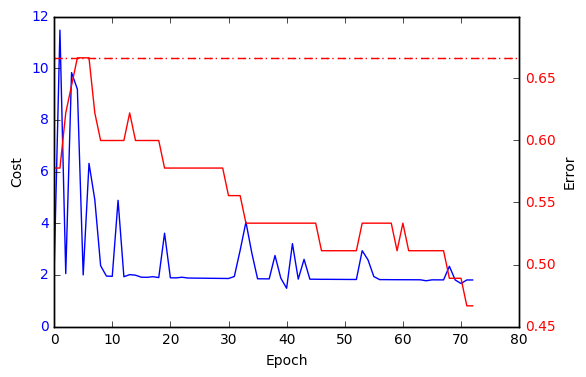

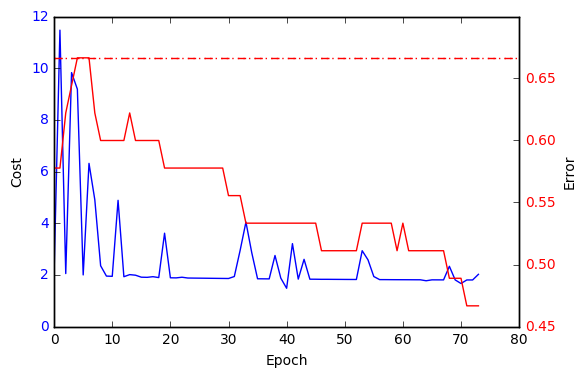

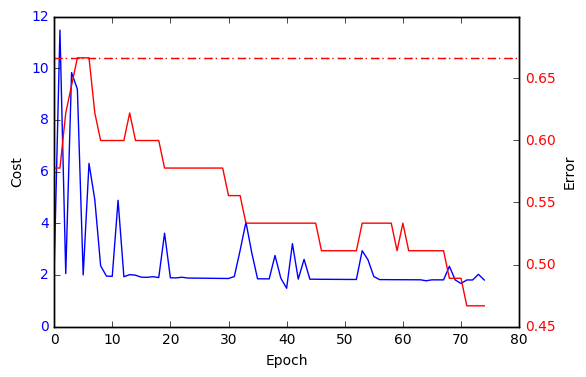

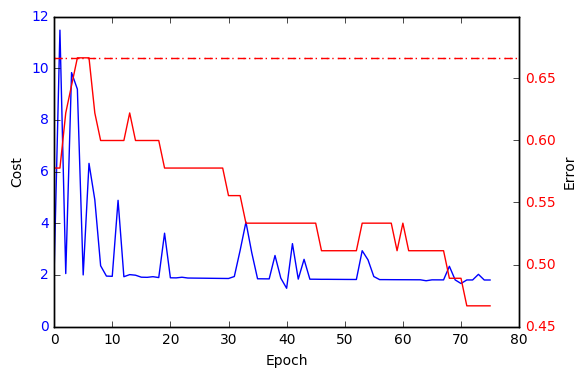

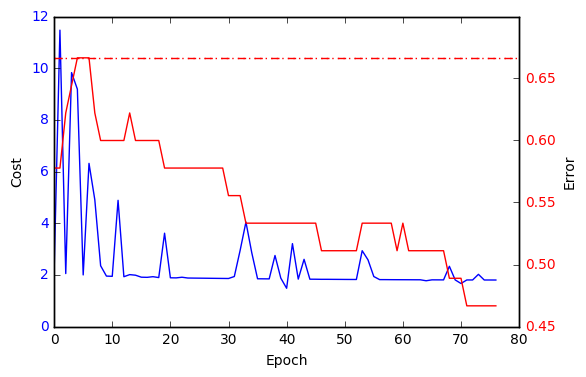

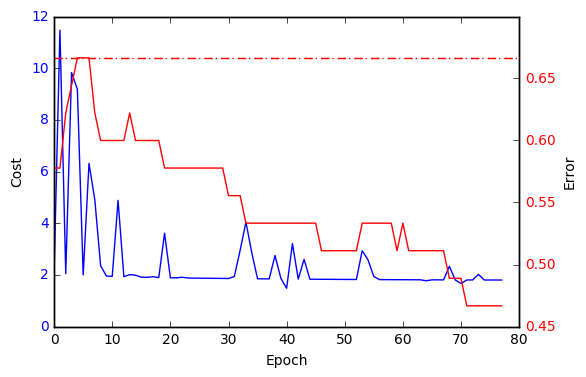

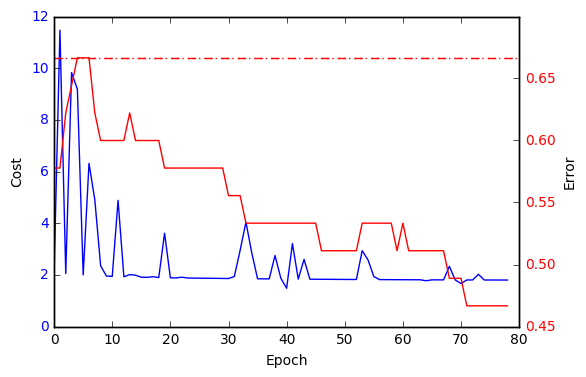

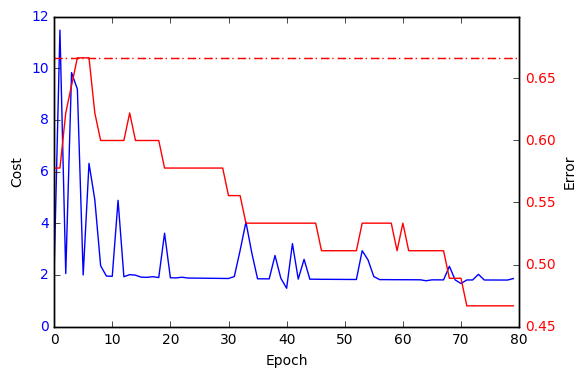

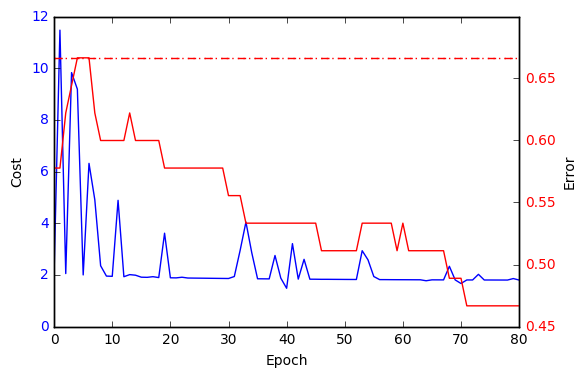

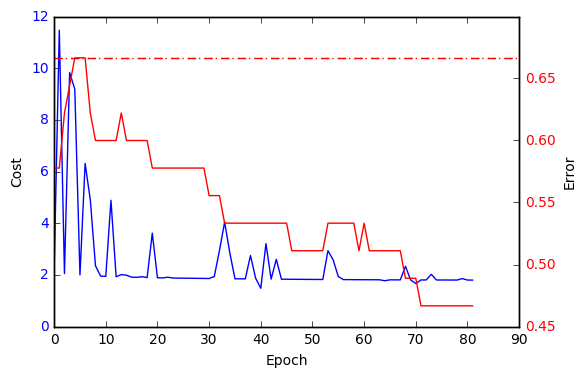

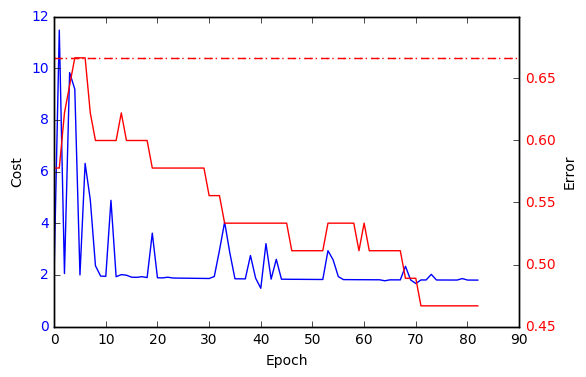

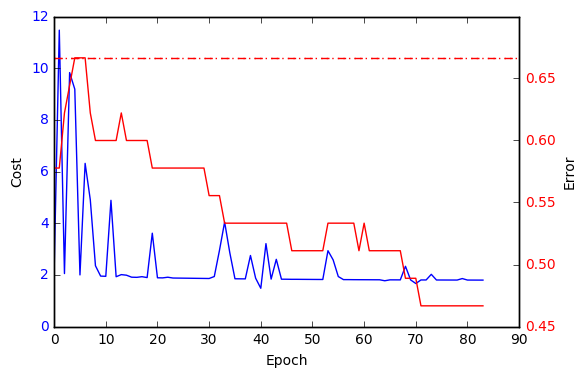

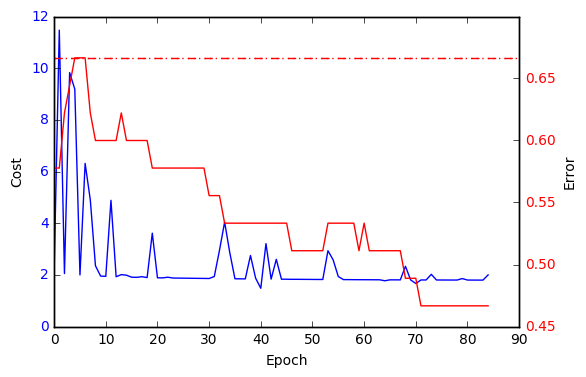

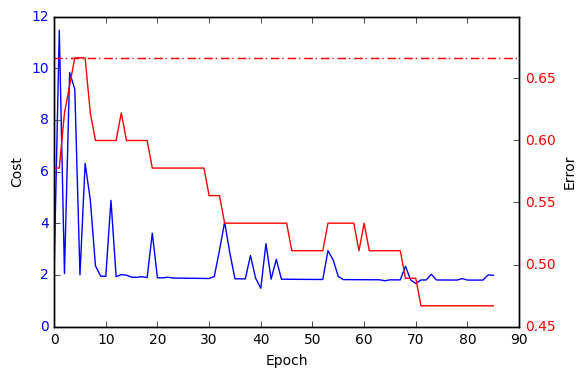

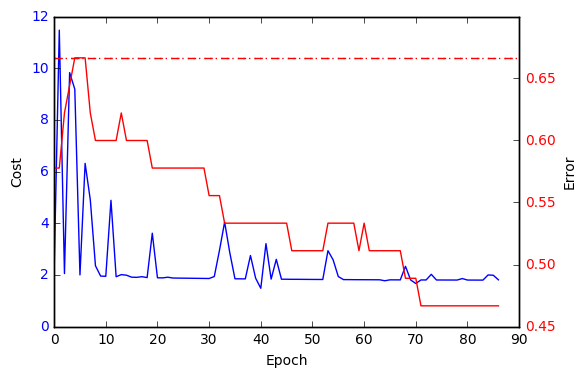

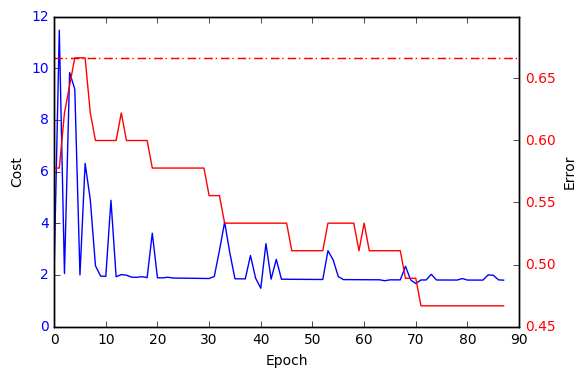

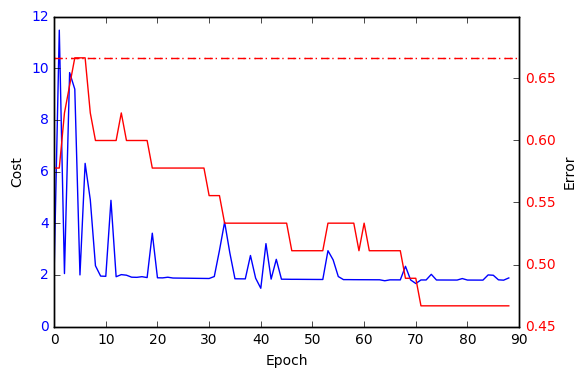

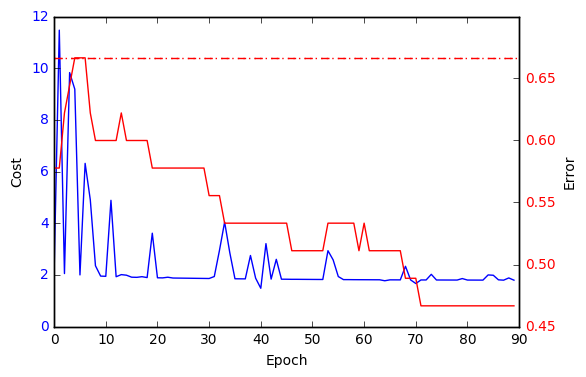

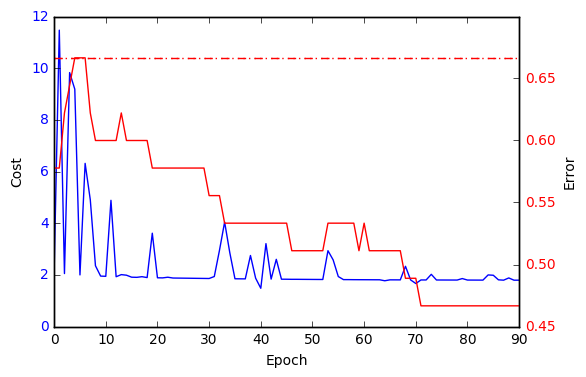

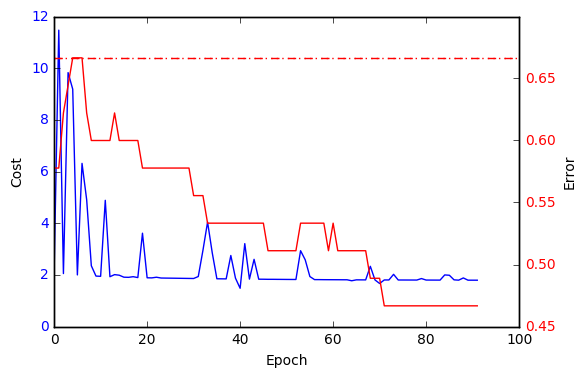

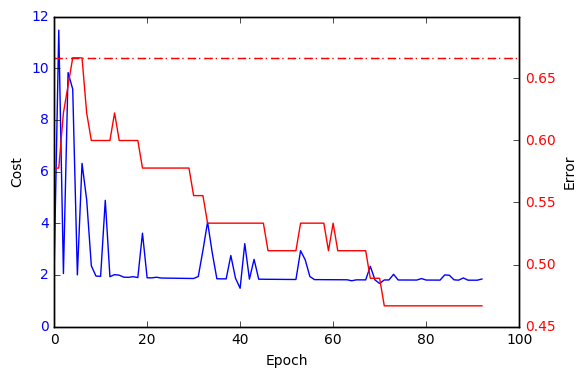

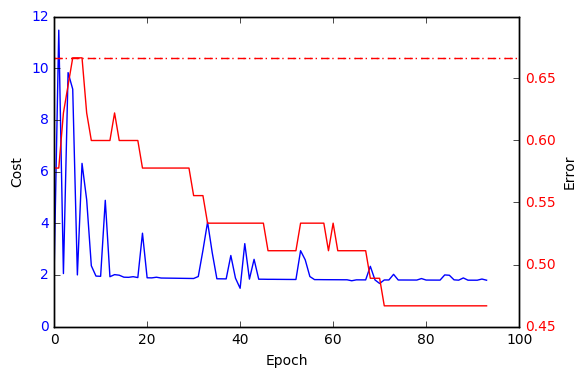

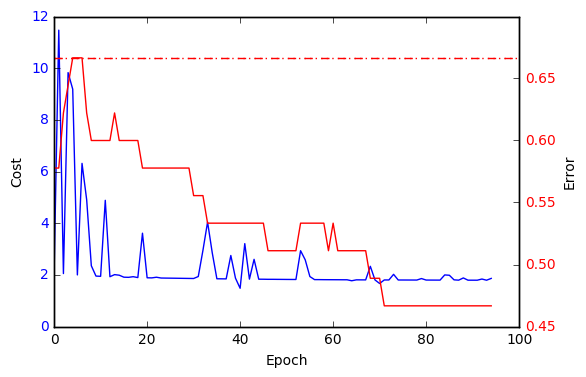

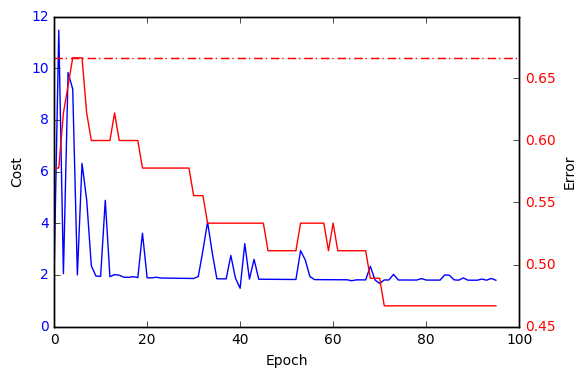

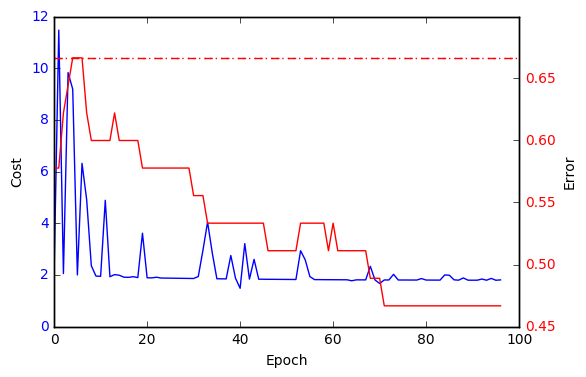

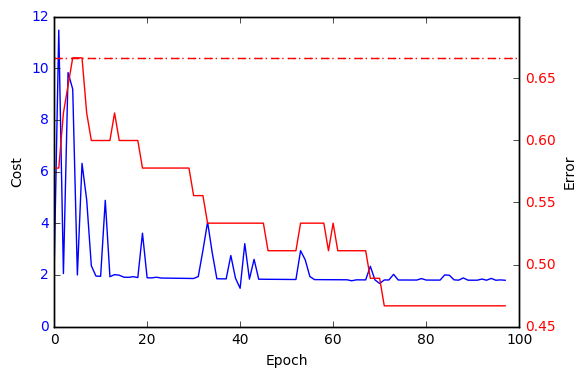

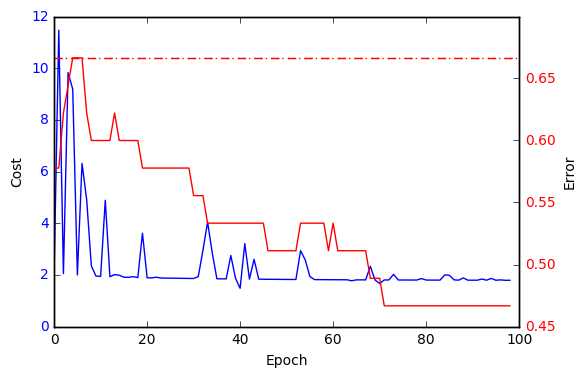

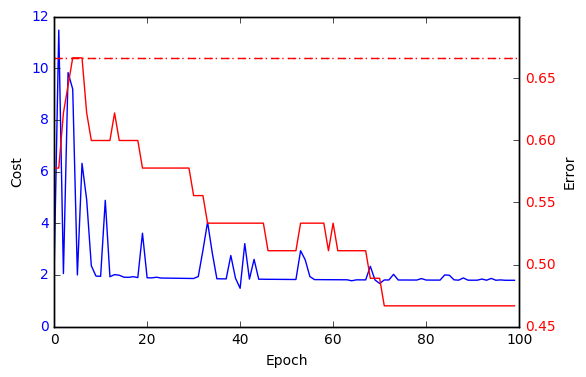

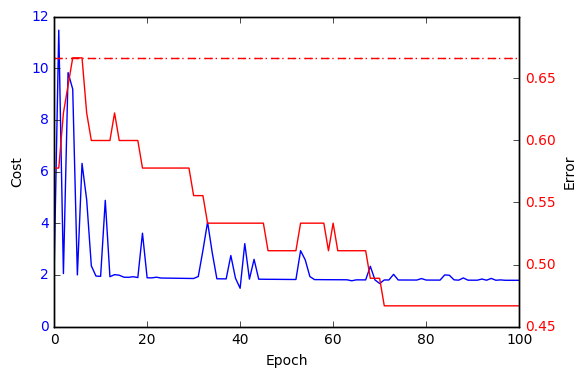

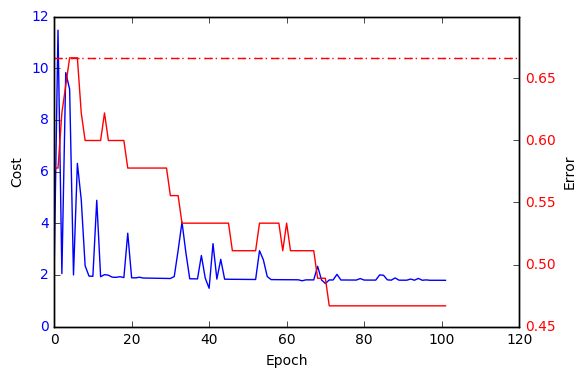

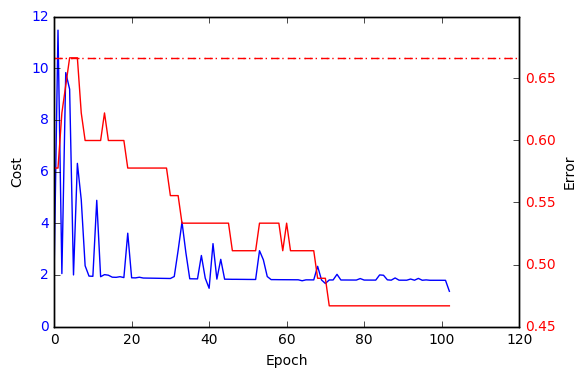

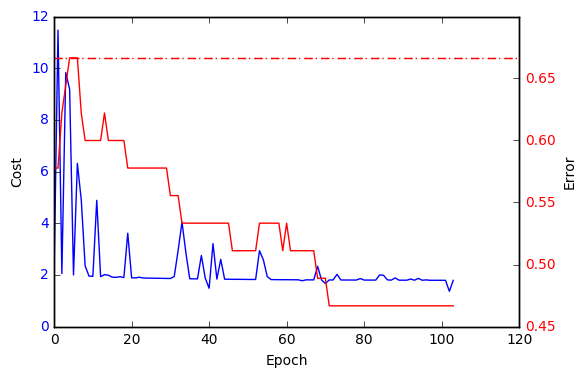

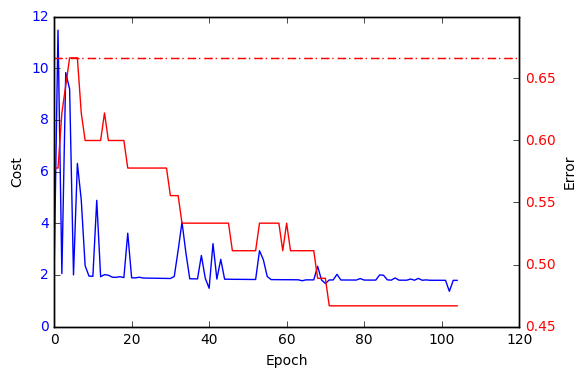

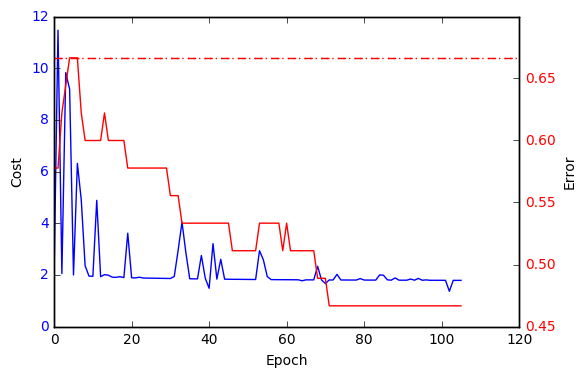

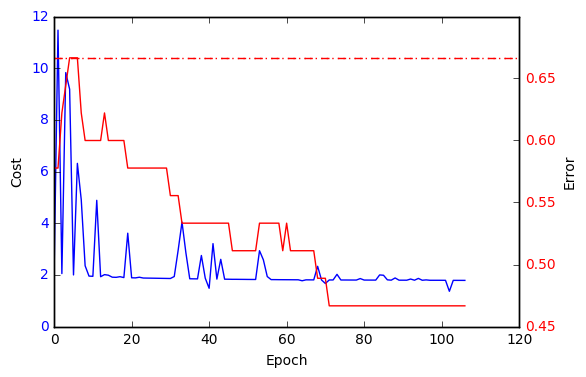

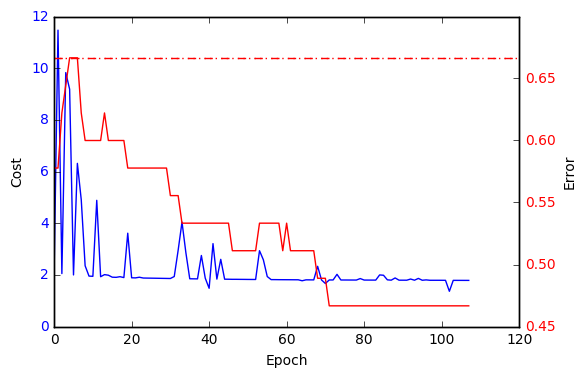

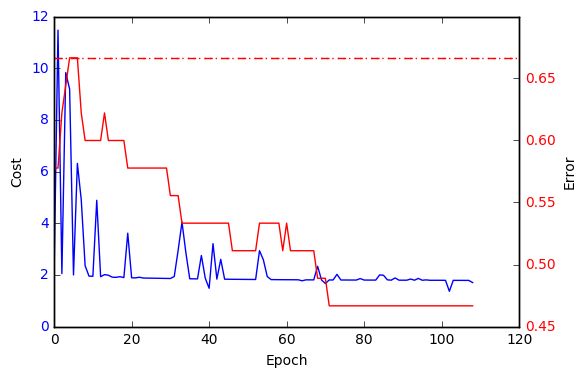

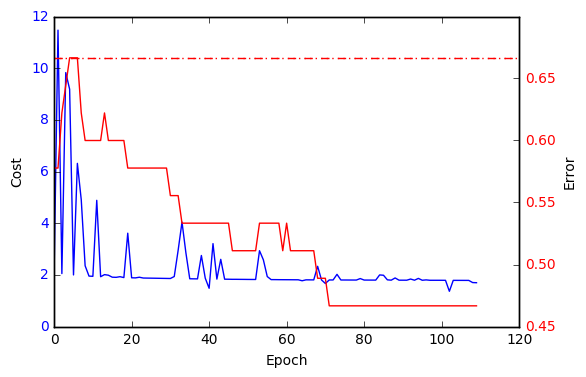

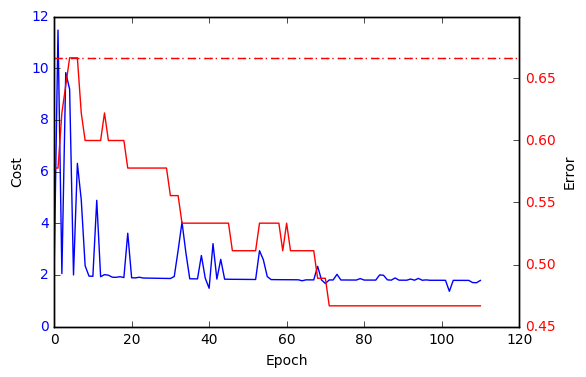

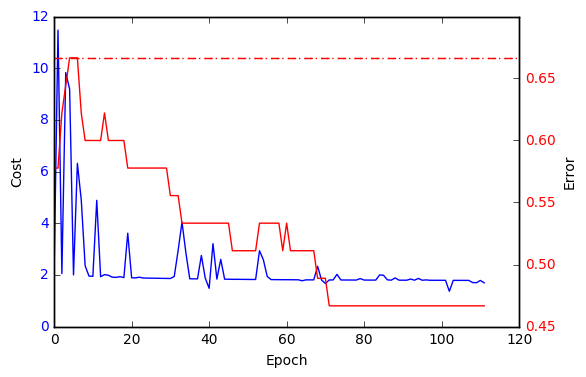

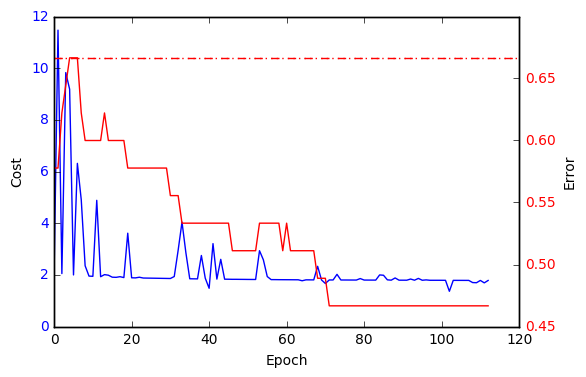

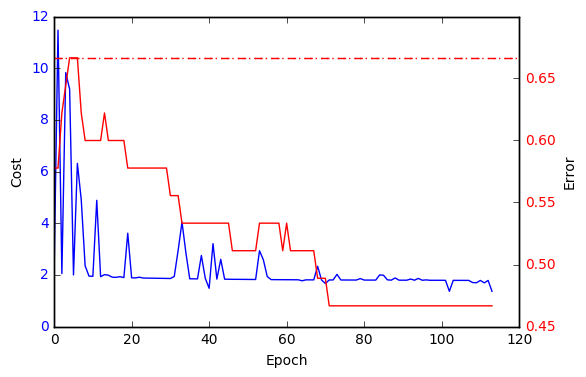

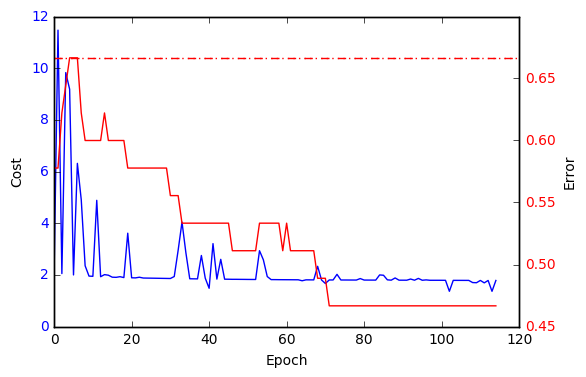

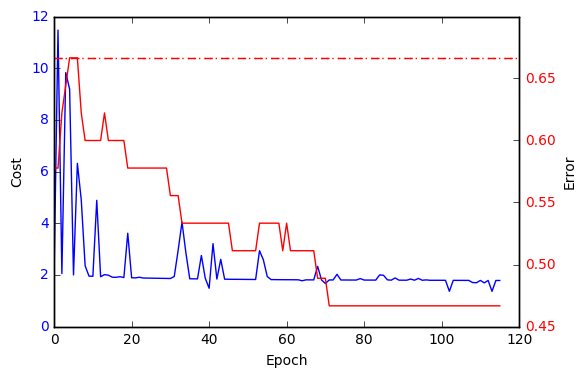

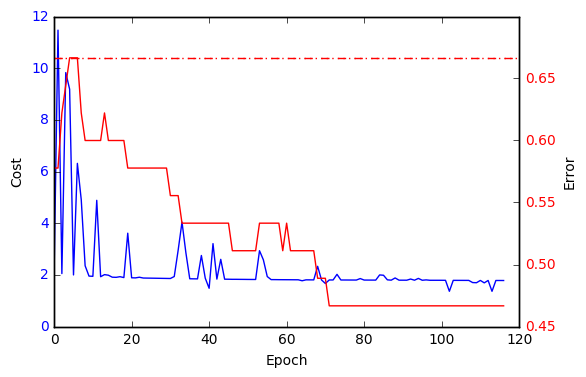

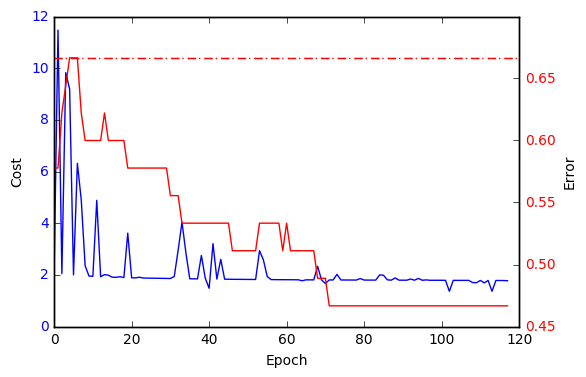

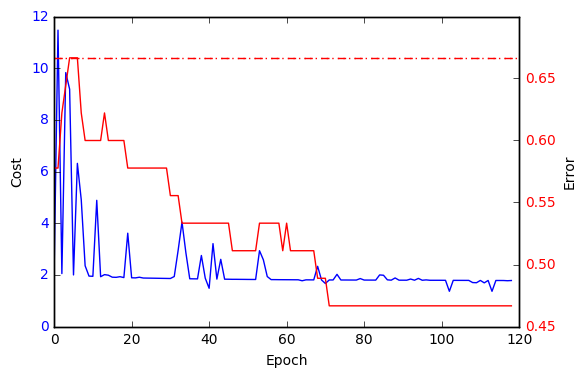

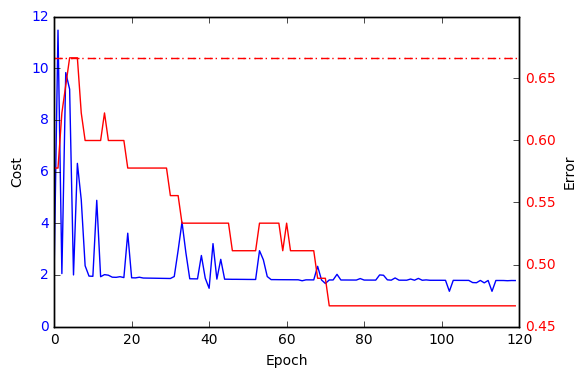

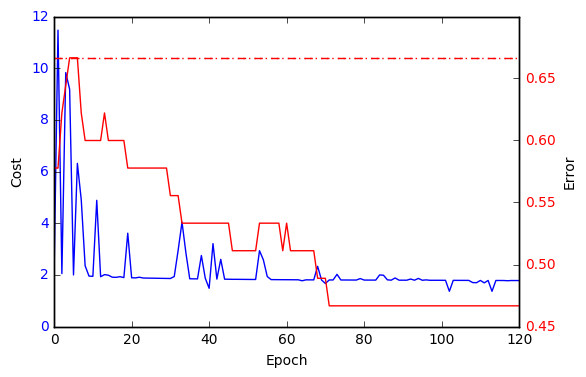

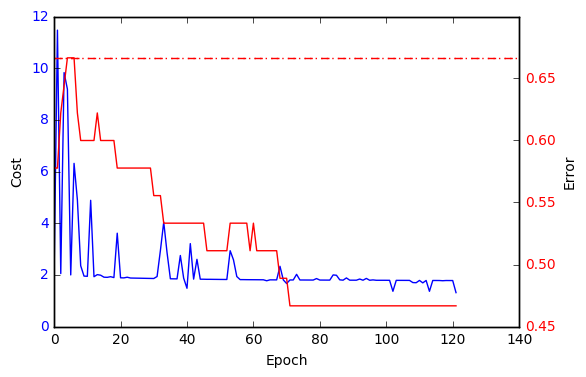

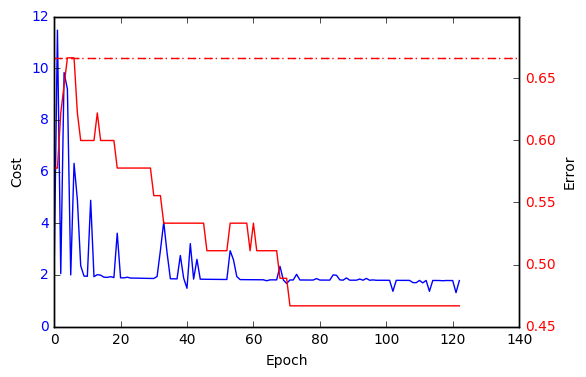

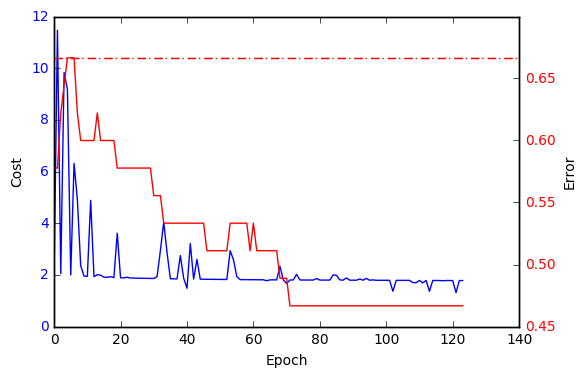

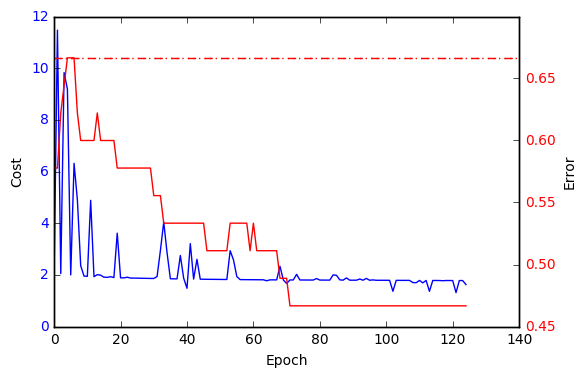

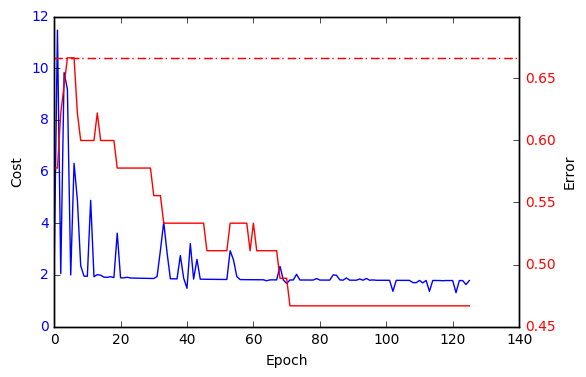

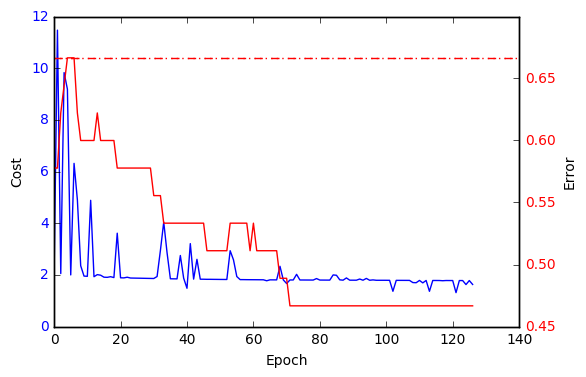

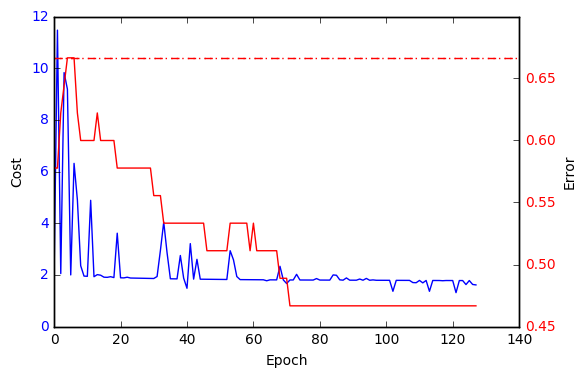

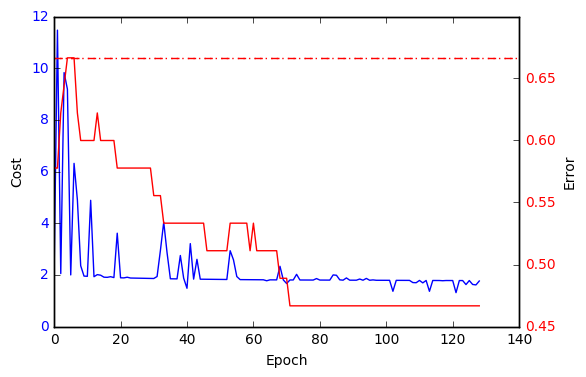

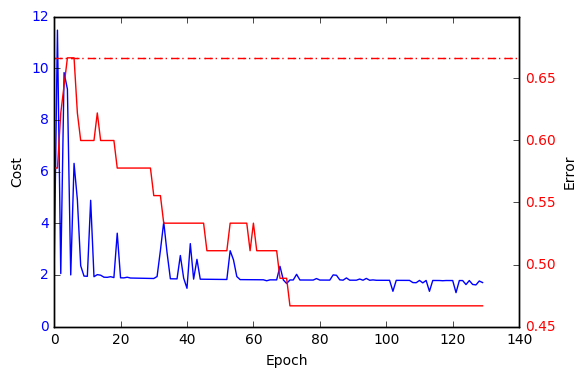

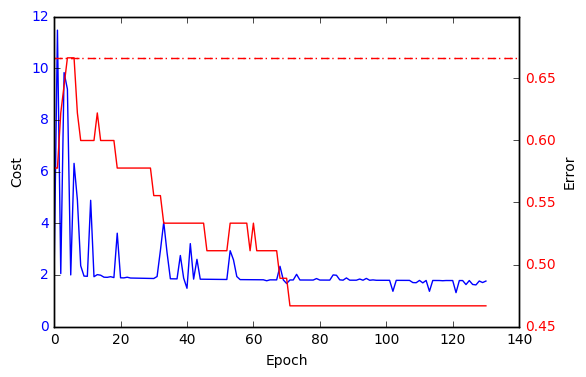

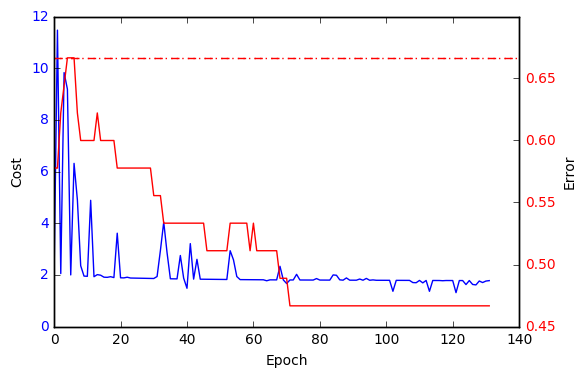

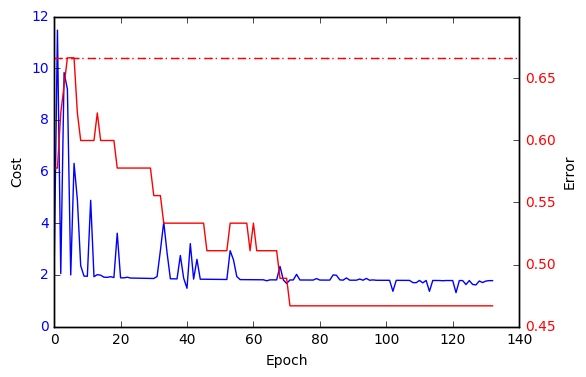

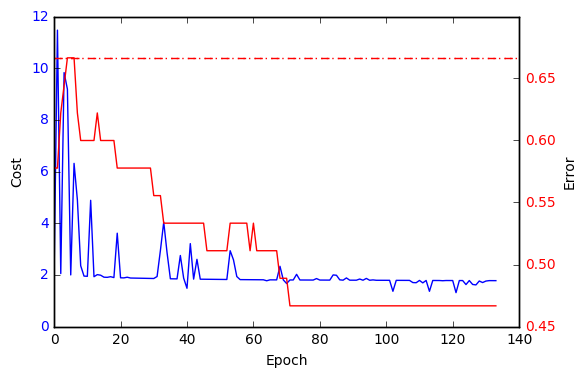

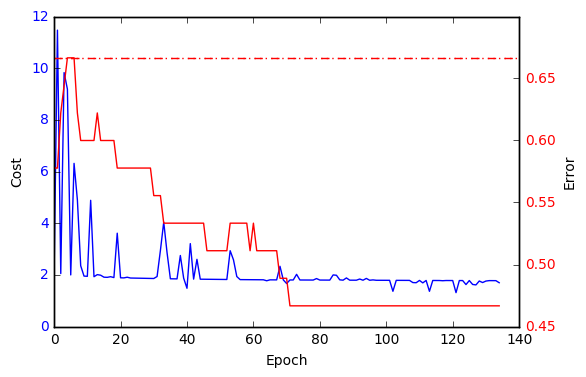

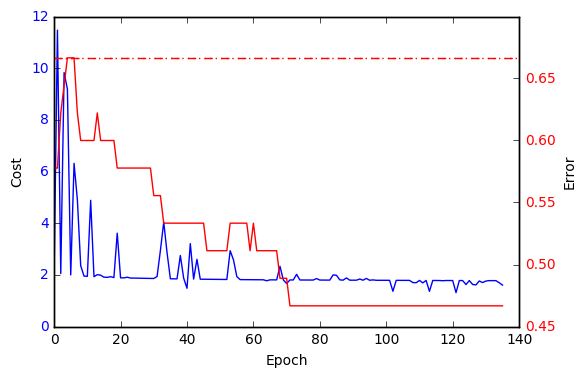

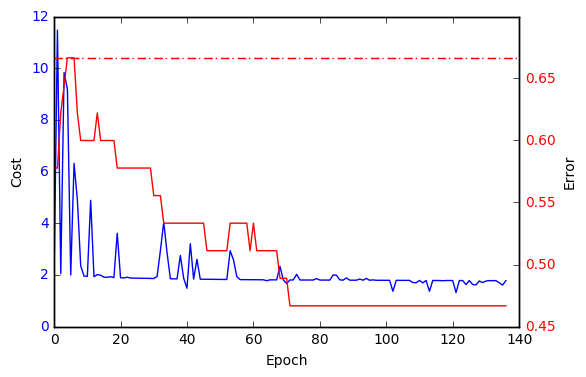

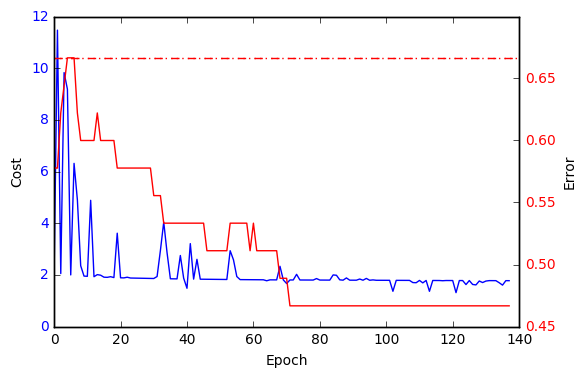

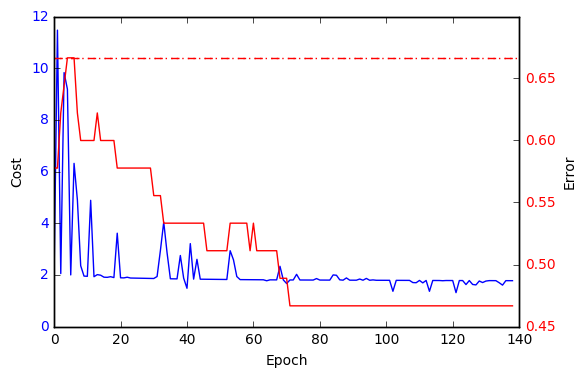

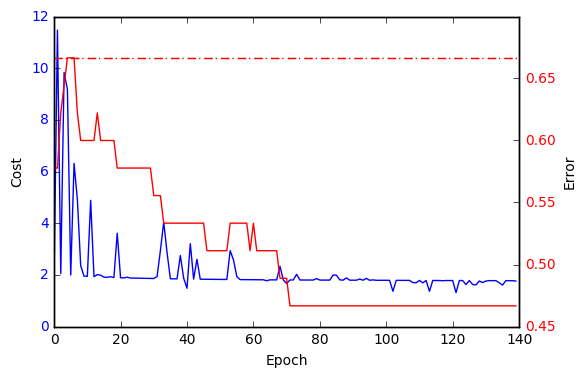

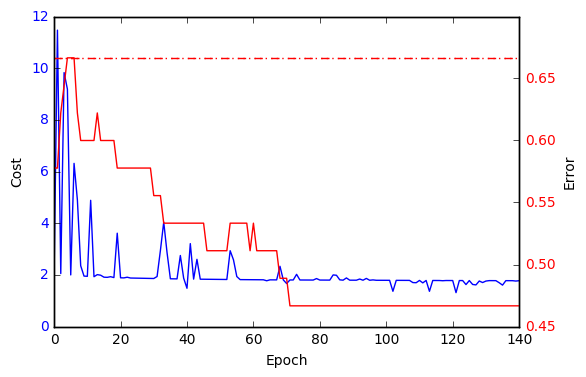

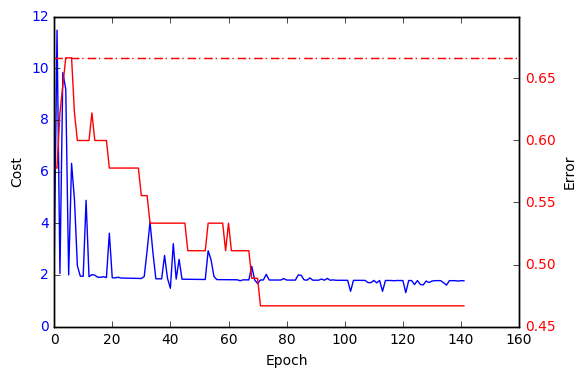

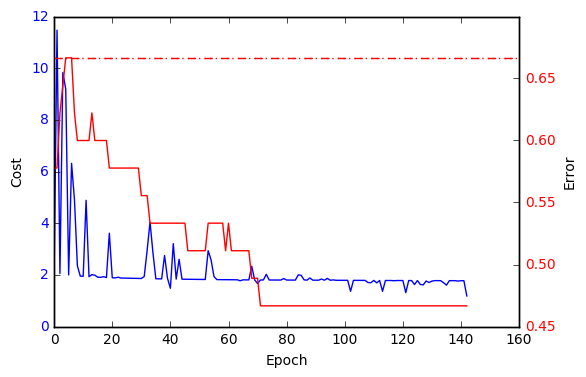

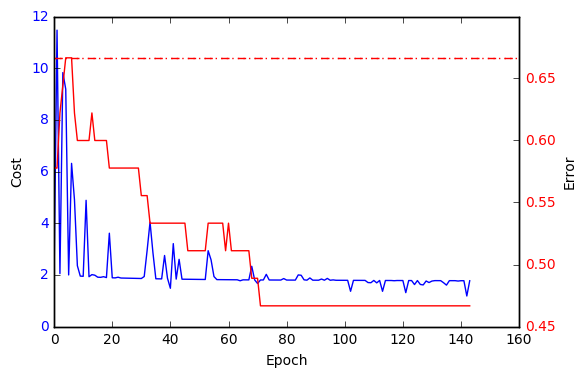

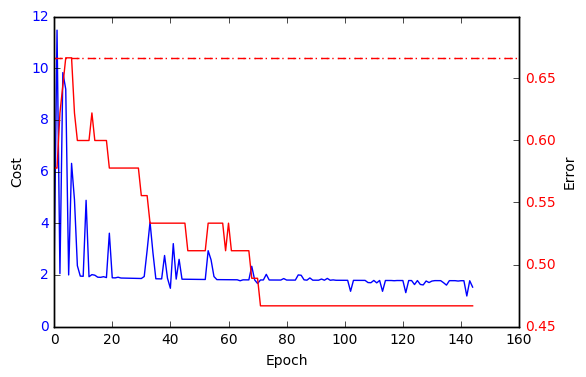

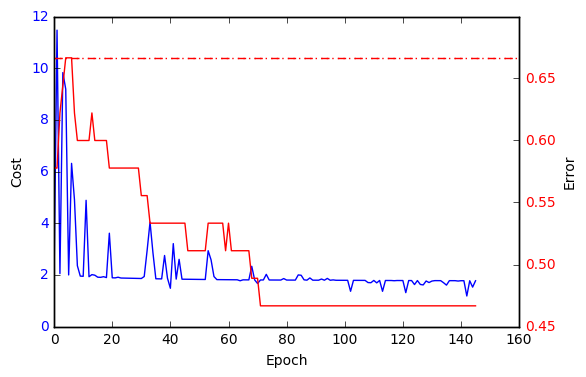

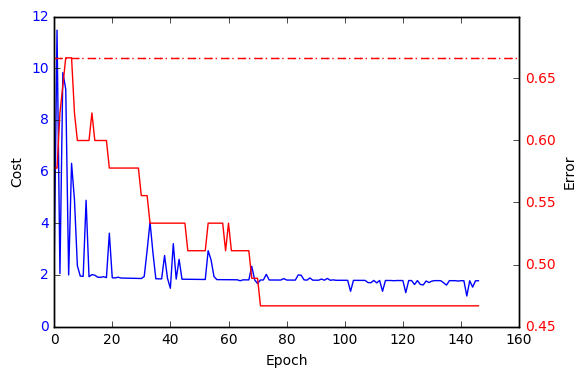

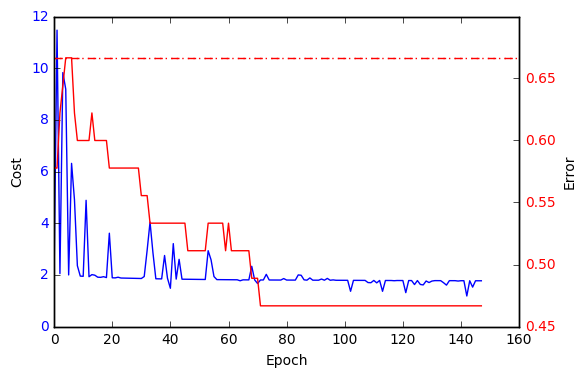

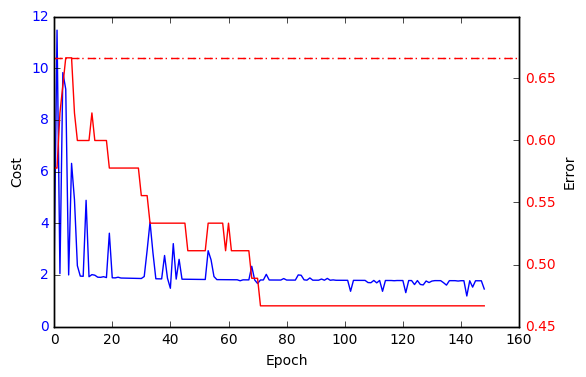

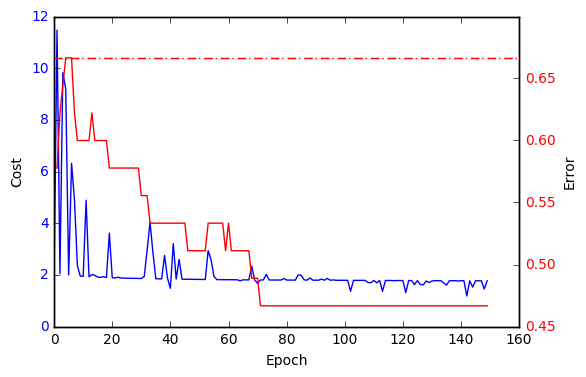

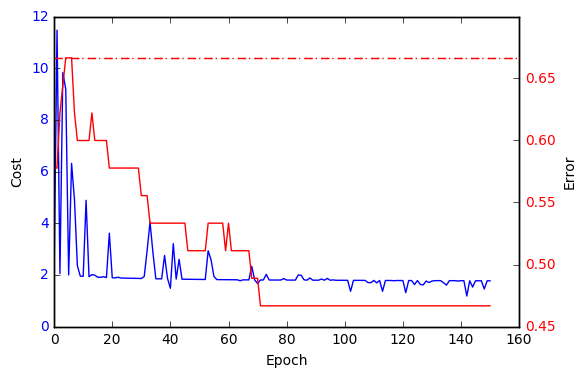

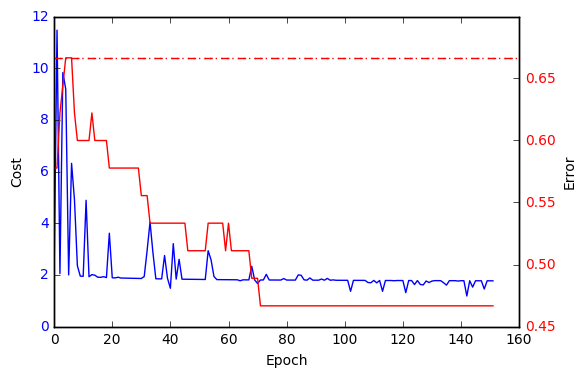

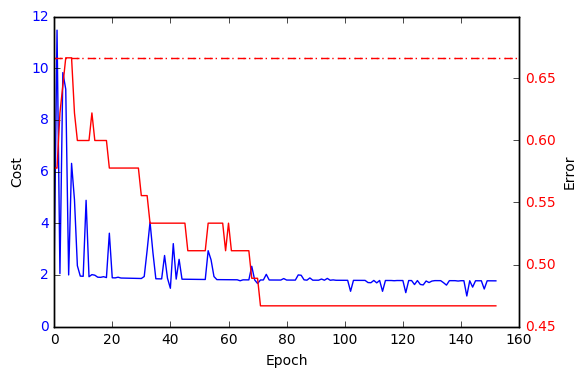

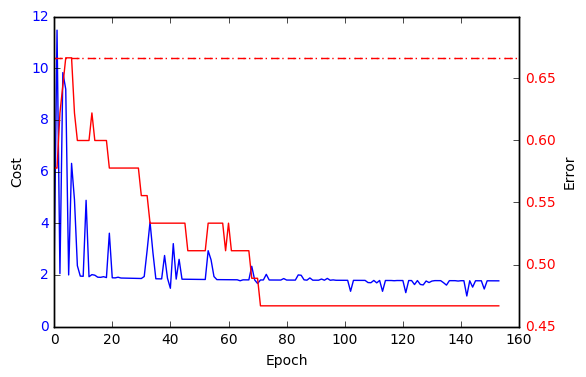

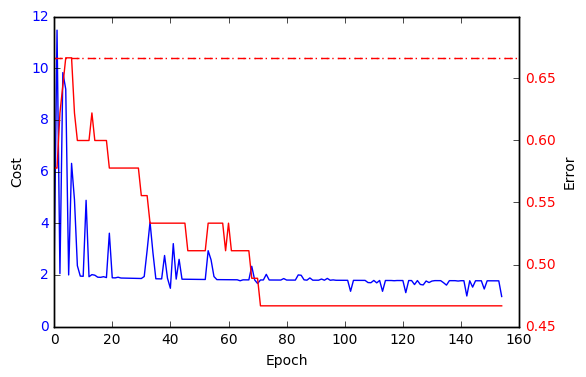

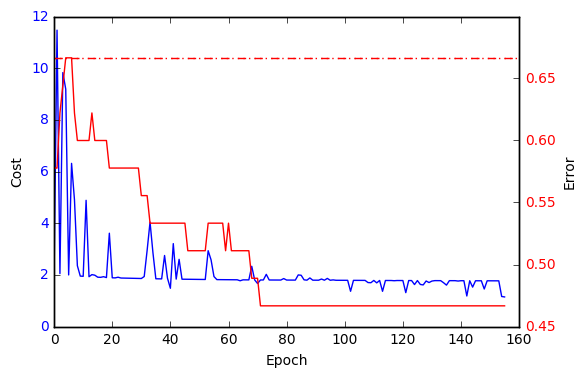

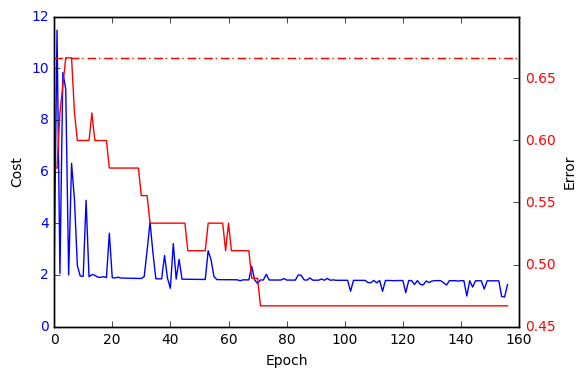

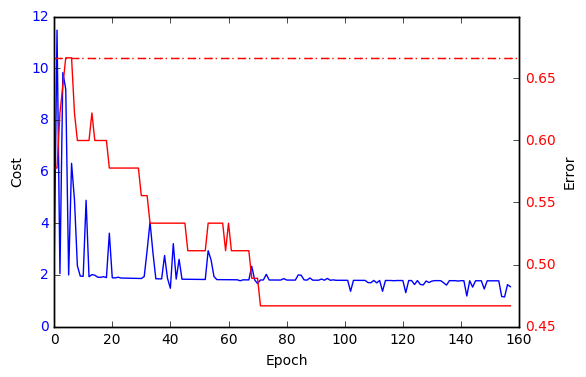

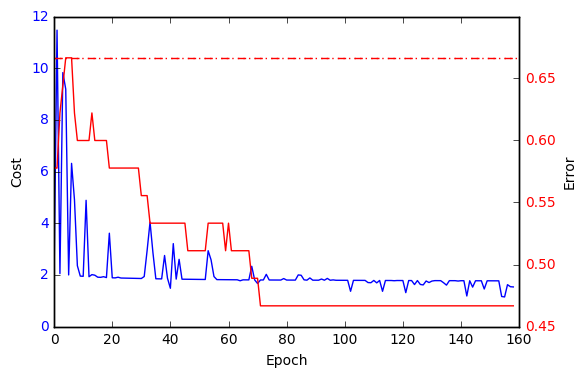

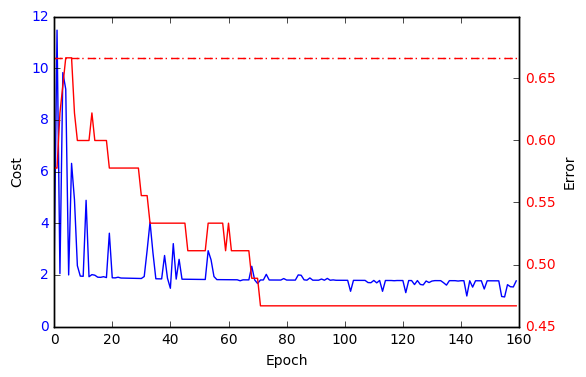

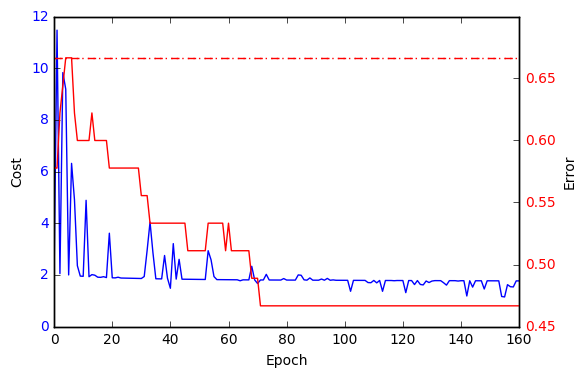

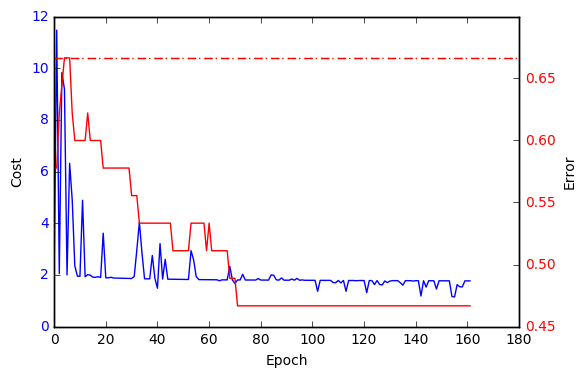

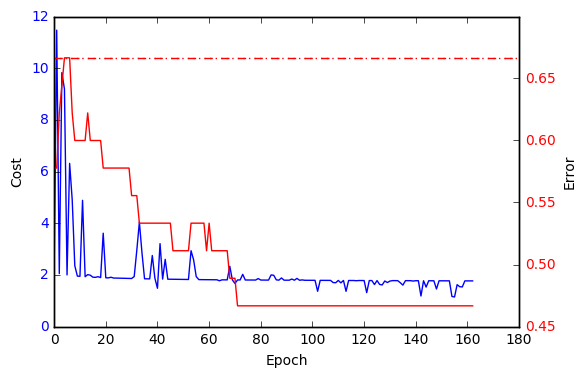

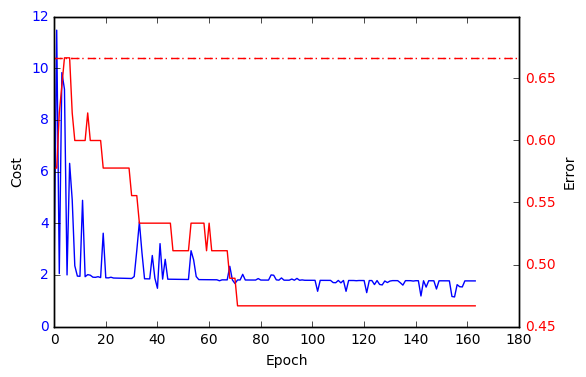

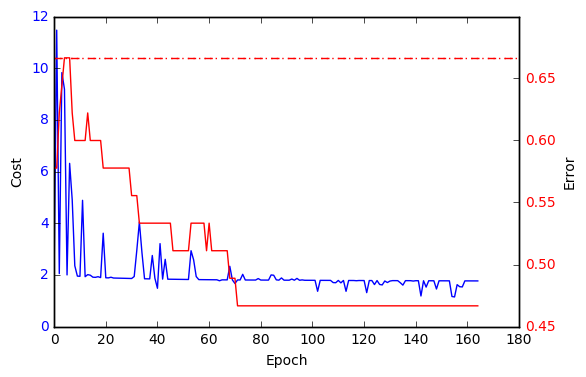

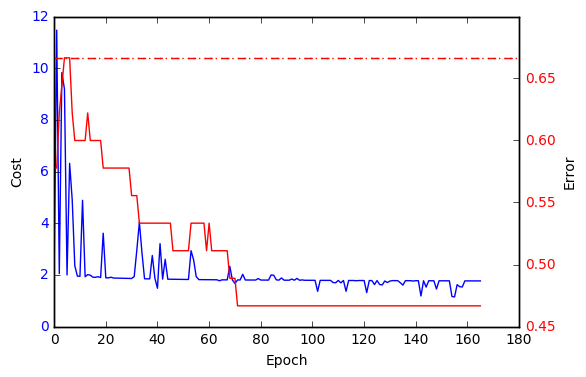

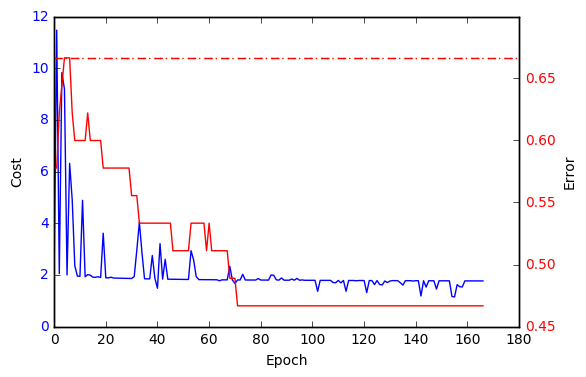

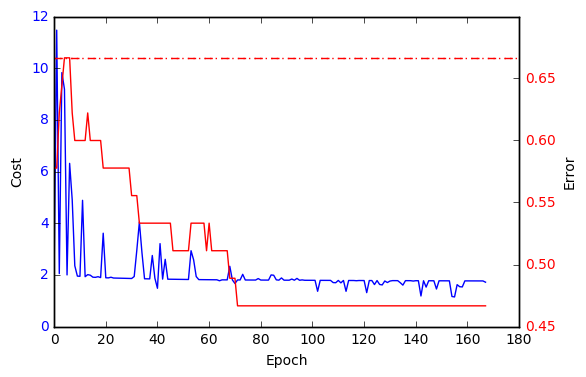

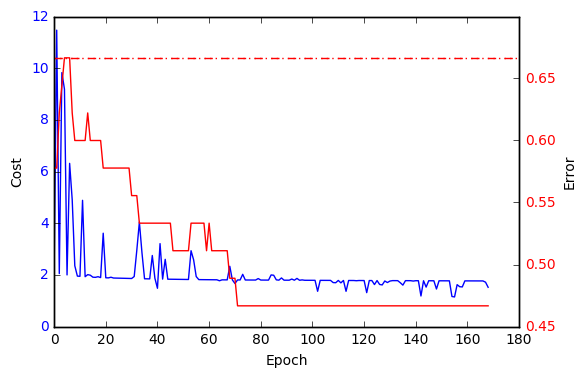

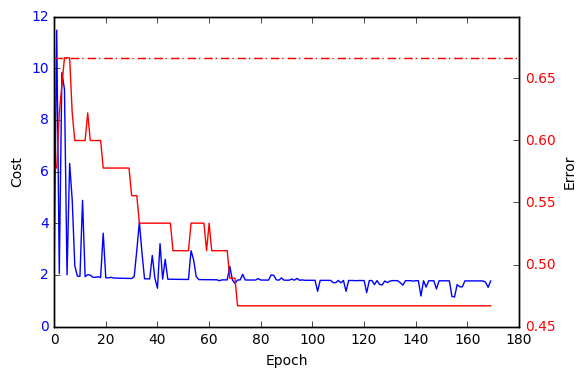

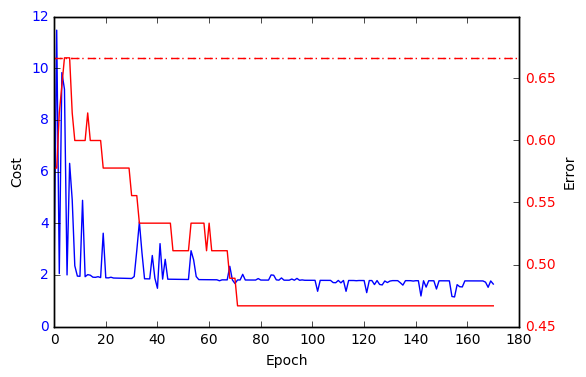

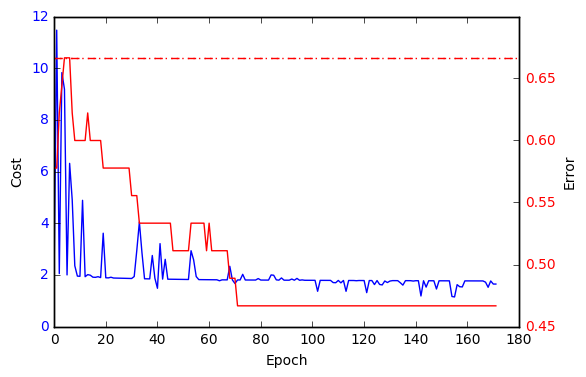

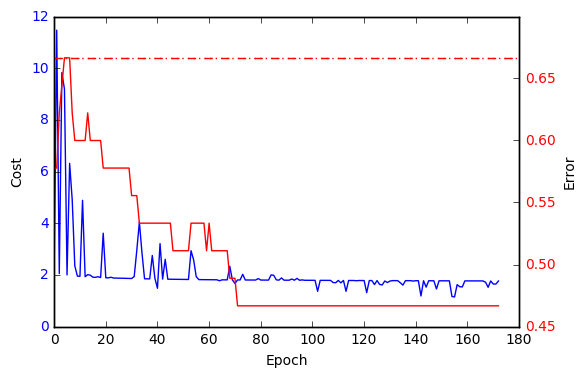

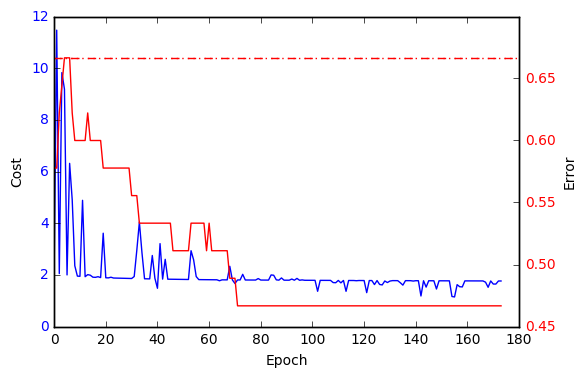

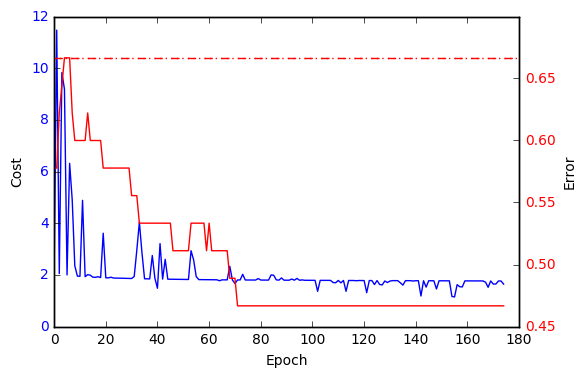

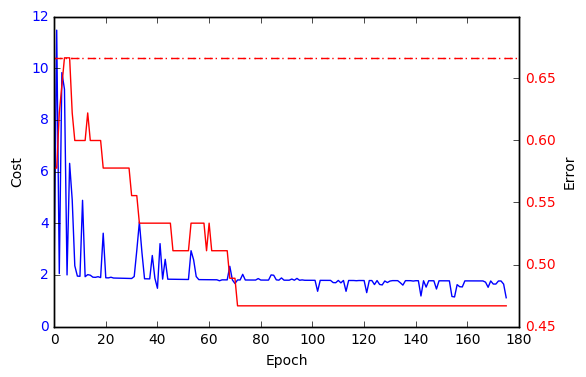

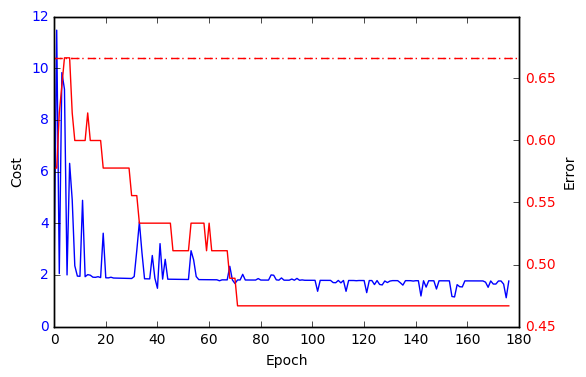

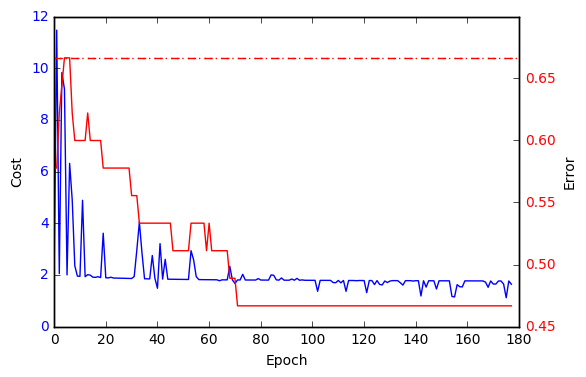

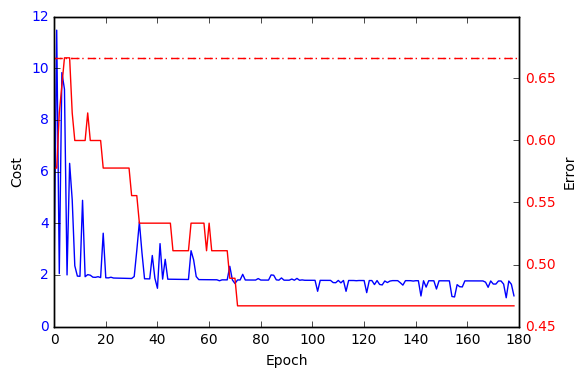

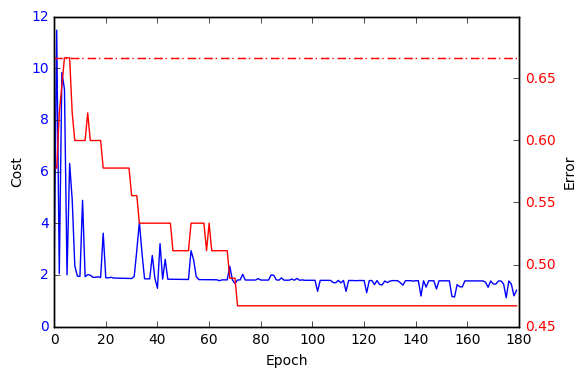

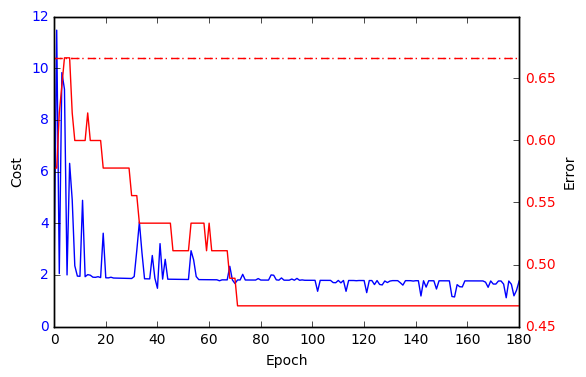

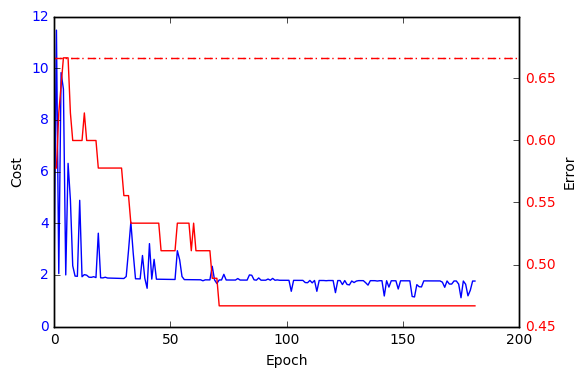

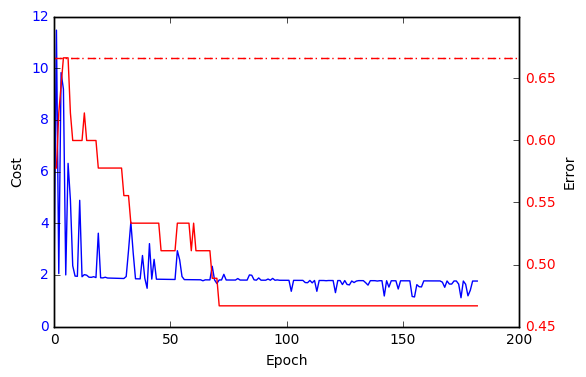

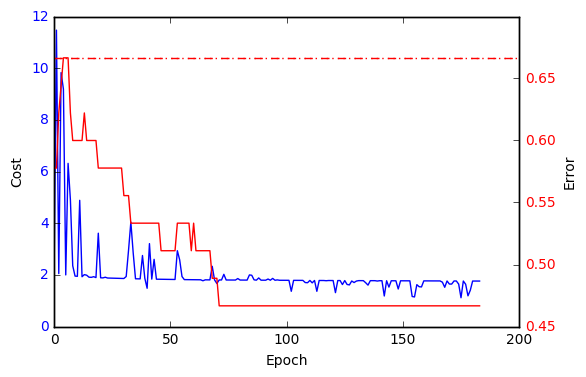

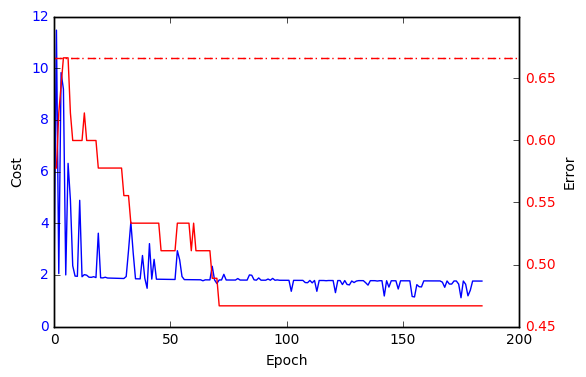

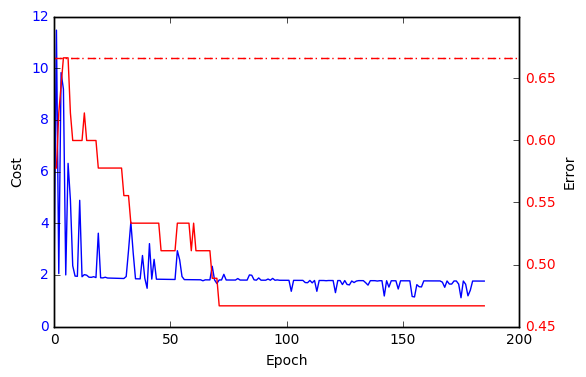

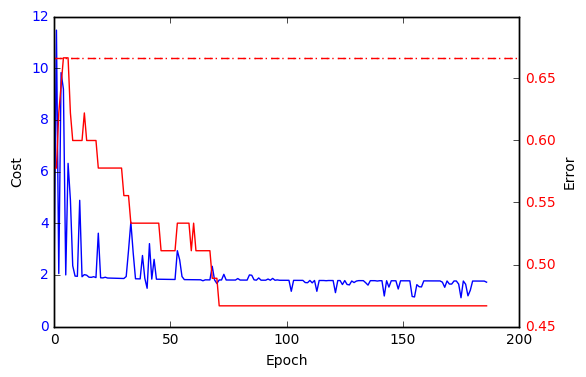

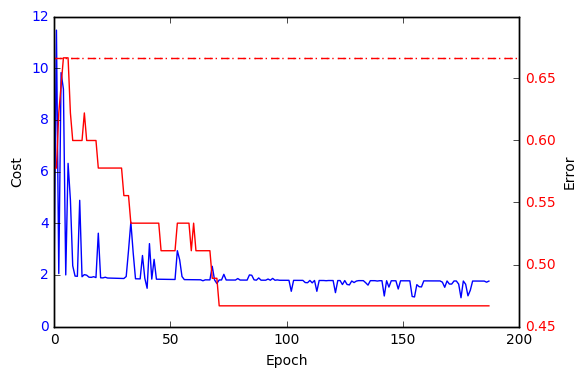

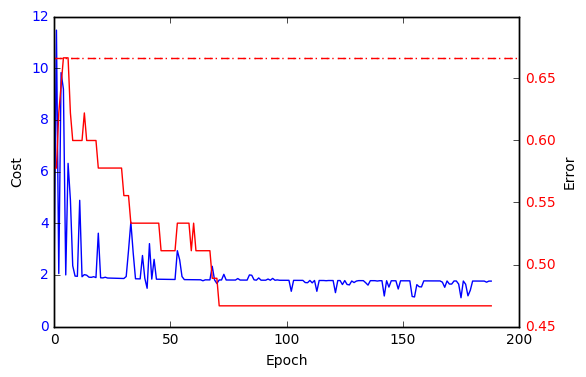

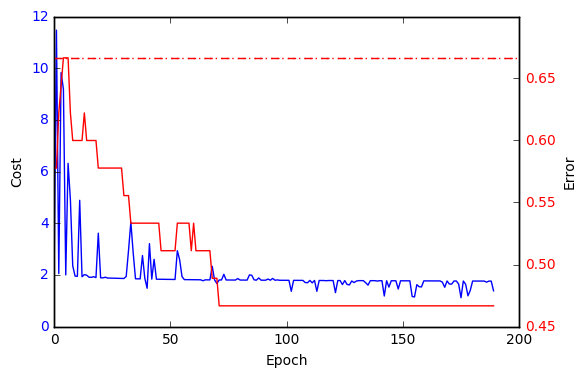

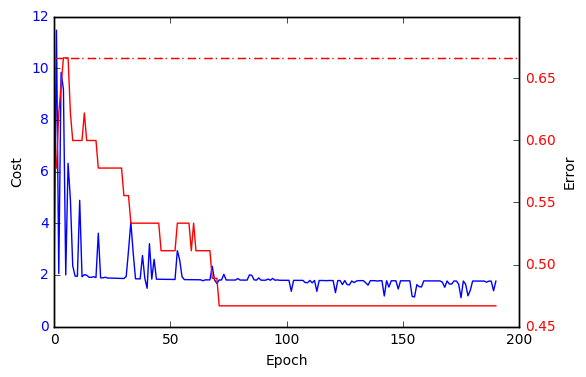

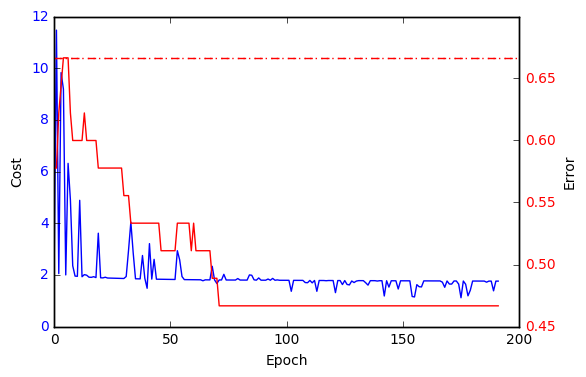

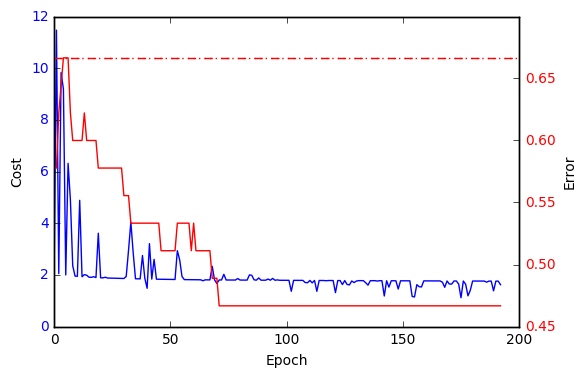

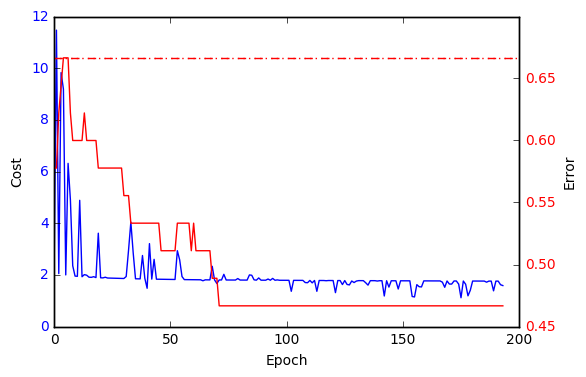

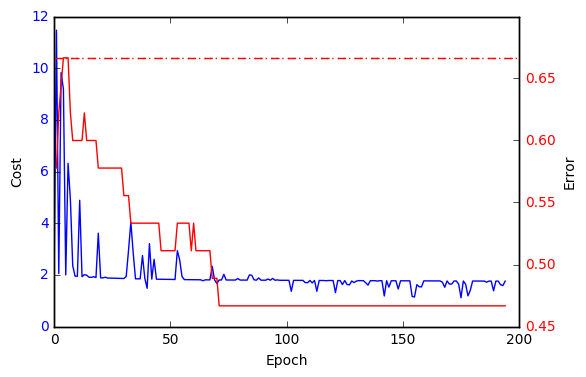

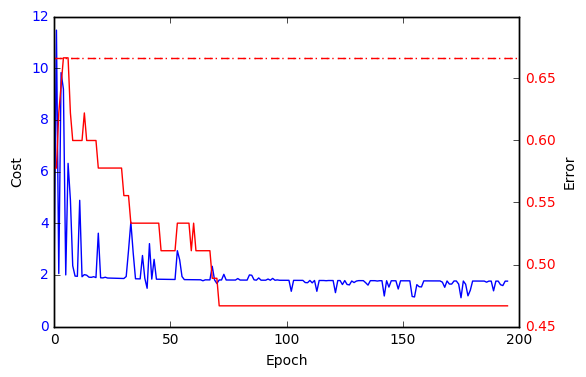

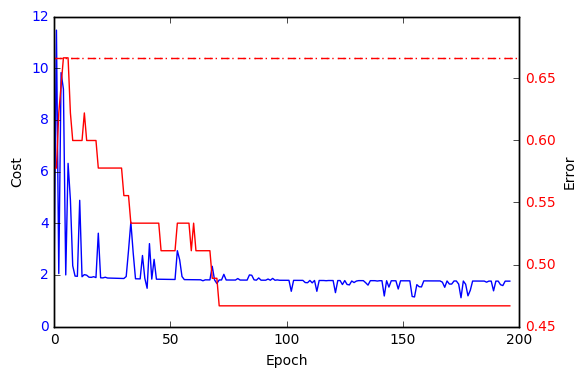

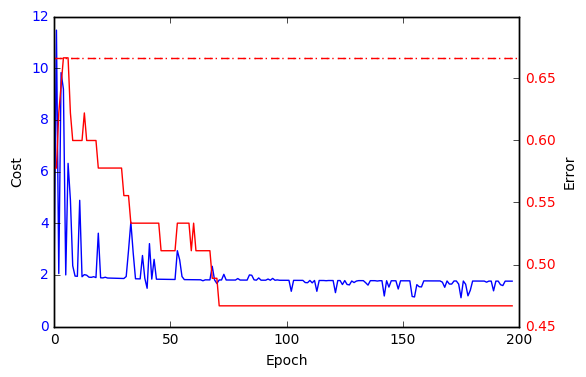

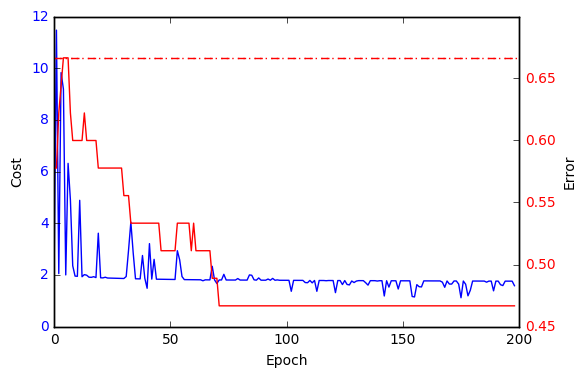

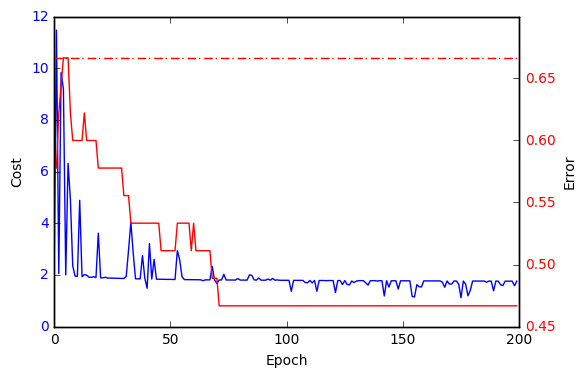

In [31]:
import time
from scipy.stats import mode

n_train_batches = int(Xtraintheano.get_value(borrow=True).shape[0] / batchsize)
n_test_batches = int(Xvaltheano.get_value(borrow=True).shape[0] / batchsize)

n_epochs = 200

plt.ion()

start = time.time()
epochs = []
costs = []
errors = []
randomerror = 1 - 1.0/len(np.unique(Yval))
mostcommonerror = np.mean(Yval != mode(Yval)[0][0]) #error from always predicting most common class
for epoch in range(n_epochs):
    epochstart = time.time()
    ypreds = np.empty((batchsize*n_test_batches, 1), dtype=int)
    #yprobs = np.empty((batchsize*n_test_batches, 1), dtype=float)
    for batchidx in range(n_train_batches):
        batchcost = train(batchidx)
        if batchcost == np.nan:
            print("NaN cost. Exiting. Try lowering the learning rate.")
            break
    for batchidx in range(n_test_batches):
        #batchyprob, batchypred = predict(batchidx)
        batchypred = predict(batchidx)
        #yprobs[batchsize*batchidx:batchsize*(batchidx+1)] = batchyprob
        ypreds[batchsize*batchidx:batchsize*(batchidx+1)] = batchypred
    #print("Epoch: {0}, runtime: {1}, cost: {2}".format(epoch, time.time()-epochstart, batchcost))
    epochs.append(epoch)
    costs.append(batchcost)
    
    epochYtest = Yval[:ypreds.shape[0]]
    #if epochYtest.shape[1]>1: #If Yval is in one-hot form change back to single int to compare with ypred
    #    epochYtest = np.argmax(epochYtest, axis=1)
    
    epochAcc = np.mean(epochYtest == ypreds)
    epochErr = np.mean(epochYtest != ypreds)
    
    errors.append(epochErr)
    
    #if epochErr < randomerror and epochErr < mostcommonerror:
    #    save_model(params, 'model-epoch_'+str(epoch))
    
    fig, ax = plt.subplots()
    ax.plot(epochs,costs, 'b-')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cost")
    for tl in ax.get_yticklabels():
        tl.set_color('b')
    
    ax1 = ax.twinx()
    ax1.plot(epochs, errors, 'r-')
    ax1.set_ylabel("Error")
    ax1.axhline(randomerror, color='r', linestyle='dashed')
    ax1.axhline(mostcommonerror, color='r', linestyle='dotted')
    for tl in ax1.get_yticklabels():
        tl.set_color('r')    
    
    epochtime = time.time()-epochstart
    print("Epoch runtime: {0:.3g}s".format(epochtime), end="\r")
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
#    if len(errors) >= 40: # Run at least for 40 epochs
#        temperrs = np.asarray(errors)
#        if epochErr >= temperrs[-30] - temperrs[-30:].std():
#            break # If error hasn't improved by 1 SD in 30 epochs, stop
    
    #print("Epoch: {0}\tAccuracy: {1:.4g}\tError: {2:.3g}\tCost: {3:.6g}\tRuntime: {4:.3g}".format(epoch, epochAcc, epochErr, batchcost, epochtime))

end = time.time()

print("Training took {0:.3g} seconds.".format(end-start))

Inspect output: predicted probabilities and final weight matrices.

In [32]:
#print(yprobs[:100])

In [33]:
w_h1.get_value()

array([[-1.06345689,  1.04818034,  1.13535357,  1.1533289 ],
       [ 0.49296799,  1.88423491, -0.71512443, -0.01255374],
       [ 1.42593658,  0.09010791, -1.58649015, -1.0722239 ],
       [ 2.09979486,  0.86308002,  1.05194914,  0.40824956]], dtype=float32)

In [34]:
w_h2.get_value()

array([[  4.54417646e-01,   2.03164726e-01,   3.17518789e-05,
         -3.44769835e-01],
       [ -3.76365811e-01,   3.95505816e-01,   3.37997699e-05,
          3.63736510e-01],
       [ -7.54104912e-01,  -5.09019792e-02,   0.00000000e+00,
         -3.29073817e-01],
       [ -3.38432677e-02,  -9.42726135e-01,  -3.06817674e-05,
         -5.65270968e-02]], dtype=float32)

In [35]:
w_h3.get_value()

array([[ -1.58952404e-04,   7.88862467e-01,   1.00133270e-01,
          8.57802927e-01],
       [ -1.17445961e-04,  -6.04471862e-01,   7.13341832e-01,
          1.98700294e-01],
       [  2.77436229e-05,   3.45671215e-05,  -3.22383858e-05,
         -3.52552888e-05],
       [ -8.12842190e-05,   2.26778135e-01,  -8.95389393e-02,
          1.75670639e-01]], dtype=float32)

In [36]:
w_o.get_value()

array([[  2.38882902e-04,   1.25653803e-01,  -1.77586509e-03],
       [ -1.23422749e-01,   2.36341238e+00,   9.79042888e-01],
       [ -7.96078052e-03,   4.13012058e-01,   1.35307878e-01],
       [ -1.28739816e-03,  -7.36515939e-01,   5.97044170e-01]], dtype=float32)

Analyse the final performance.

In [37]:
errors = np.asarray(errors)
print("Minimum error at epoch {0}: {1:.3g} (Accuracy: {2:.4g})".format(errors.argmin(), errors[errors.argmin()], 1-errors[errors.argmin()]))

Minimum error at epoch 71: 0.467 (Accuracy: 0.5333)


In [38]:
n_test_batches = int(Xvaltheano.get_value(borrow=True).shape[0] / batchsize)

results = np.empty((batchsize*n_test_batches, 1),dtype=int)
#resultprobs = np.empty((batchsize*n_test_batches, 1),dtype=float)
for batchidx in range(n_test_batches):
    #resultprobs[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)[0]
    #results[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)[1]
    results[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)
    
results = np.asarray(results, dtype=int)
results = results.flatten()

In [39]:

#Yval_testing = Yval_testing.reshape(Yval_testing.shape[0],)

Yval_testing = Yval[:results.shape[0]]
Xval_testing = Xval[:results.shape[0]]

#if Yval_testing.shape[1] > 0:
#    Yval_testing = np.argmax(Yval_testing, axis=1
Yval_testing = Yval_testing.flatten()
Yval_testing = np.asarray(Yval_testing, dtype=int)

In [40]:
NN_accuracy = np.mean(Yval_testing == results)

print("Accuracy: {0:.2g}".format(NN_accuracy))
print("\n(Accuracy of random guesses: {0:.2g})".format(1.0/len(np.unique(epochYtest))))
print("\n(Accuracy of predicting dominant class for all: {0:.2g})".format(np.mean(Yval == mode(Yval)[0][0])))

Accuracy: 0.53

(Accuracy of random guesses: 0.33)

(Accuracy of predicting dominant class for all: 0.33)


In [41]:
print(results[:30])
print(Yval_testing[:30])

[2 2 0 0 0 0 0 2 0 2 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 2 2 0 0]
[2 2 0 0 1 0 1 2 0 1 0 2 0 2 1 2 1 1 1 0 1 2 0 1 2 2 2 2 1 2]


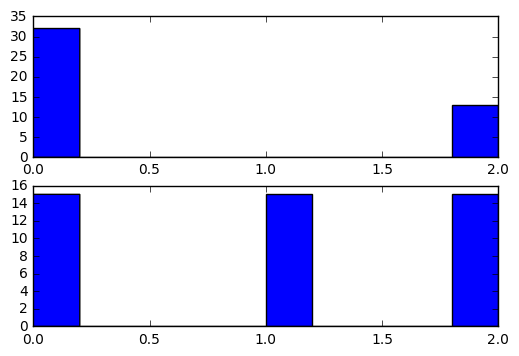

In [42]:
plt.figure(1)
plt.subplot(211)
plt.hist(results)
plt.subplot(212)
plt.hist(Yval_testing)
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, target_names):
    ncls = len(set(y_true))
    cm = confusion_matrix(y_true, y_pred)

    
    # Normalise each row to its total (i.e. normalise by the number of samples in each class)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(12,12))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    #plt.cm.Blues
    #res = ax.imshow(np.array(cm_normalised), cmap=plt.cm.jet, 
    #                interpolation='nearest')
    res = ax.pcolor(np.array(cm_normalised))


    height = cm.shape[0]
    width = cm.shape[1]

    for x in range(ncls):
        for y in range(ncls):
            ax.annotate(str(cm[x][y]), xy=(y+0.5, x+0.5), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=20,color='w')

    cb = fig.colorbar(res,fraction=0.046, pad=0.04)

    #plt.imshow(cm_normalised, cmap='jet')
    
    plt.xticks(np.arange(ncls)+0.5, target_names, fontsize=16,rotation='vertical')
    plt.yticks(np.arange(ncls)+0.5, target_names, fontsize=16)
    #plt.tight_layout()
    plt.xlabel("Predicted label", fontsize=20)
    plt.ylabel("True label", fontsize=20)
    plt.title("Confusion matrix", fontsize=22)
    fig=plt.figure()

    return fig

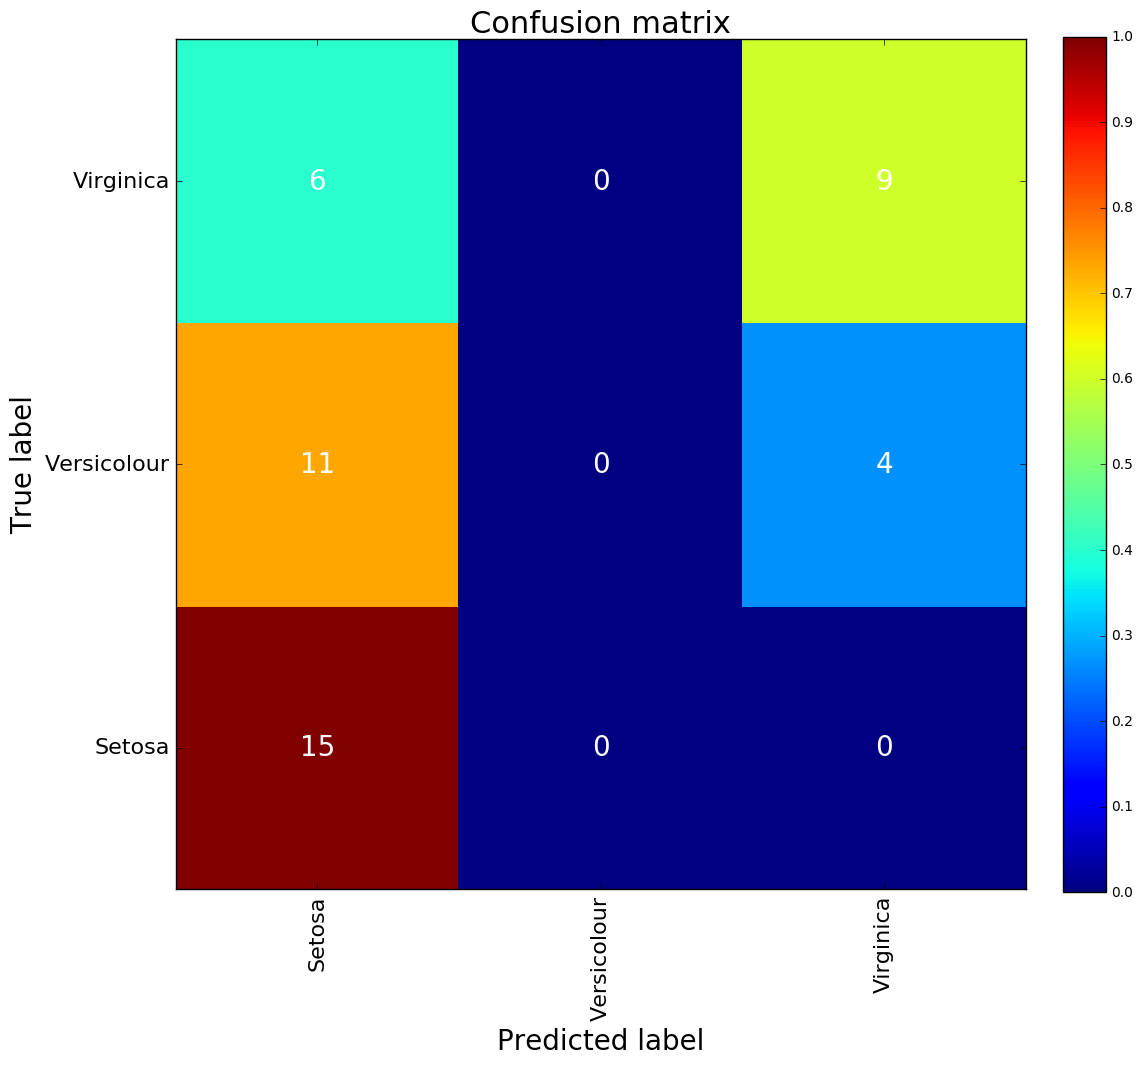

In [44]:
target_names = ['Setosa', 'Versicolour','Virginica']
#target_names = [str(i) for i in np.unique(np.concatenate((Ytrain, Yval_testing), axis=0))]

#print(confusion_matrix(Yval_testing, results))
plot_confusion_matrix(Yval_testing, results, target_names=target_names)
plt.show()

In [45]:
from sklearn.metrics import classification_report

print(classification_report(Yval_testing, results, target_names=target_names))

             precision    recall  f1-score   support

     Setosa       0.47      1.00      0.64        15
Versicolour       0.00      0.00      0.00        15
  Virginica       0.69      0.60      0.64        15

avg / total       0.39      0.53      0.43        45



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Benchmark agains other similar classifiers, possibly one simple and similar one as a baseline, and one usually performant one (e.g. XGBoost) as a benchmark.

In [46]:
# Concatenate training and validation sets and undo one-hot encoding for sklearn classifiers to run CV
Xsklearn = np.concatenate((Xtrain,Xval), axis=0)

if Ytrain.shape[1] > 0:
    Ysklearn = np.concatenate((np.argmax(Ytrain, axis=1), Yval.flatten()),axis=0)
else:
    np.concatenate((Ytrain,Yval), axis=0)

In [47]:
from sklearn.cross_validation import cross_val_score

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [48]:
from sklearn import linear_model
clf = linear_model.Perceptron()

score = cross_val_score(clf, Xsklearn, Ysklearn, cv=3)

print(score)
print(score.mean())

[ 0.74509804  0.90196078  0.875     ]
0.84068627451


In [49]:
# If you have XGBoost installed you can benchmark against it as well:

# For description of XGBoost algorithm see:
#  http://xgboost.readthedocs.io/en/latest/model.html

from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
#clf = XGBClassifier()
score = cross_val_score(clf, Xsklearn, Ysklearn, cv=3)

print(score)
print(score.mean())

[ 0.92156863  0.94117647  0.95833333]
0.940359477124


Apply a shallow (desired for interpretability, see later) decision tree to the data, as a benchmark.

In [50]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)

[ 0.92156863  0.90196078  0.95833333]
0.927287581699


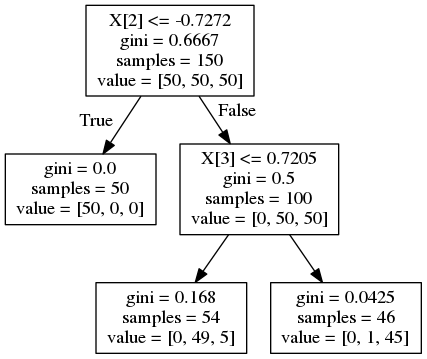

In [51]:
score = cross_val_score(clf, Xsklearn, Ysklearn, cv=3)

print(score)
print(score.mean())

clf = tree.DecisionTreeClassifier(max_depth=2)
clf_data_to_target = clf.fit(Xsklearn, Ysklearn)
tree.export_graphviz(clf_data_to_target, out_file='tree.dot')

# sudo apt-get install graphviz
!dot -Tpng tree.dot -o tree.png

from IPython.display import Image
Image(filename='tree.png') 

Now use a decision tree to fit the NN results from the input data

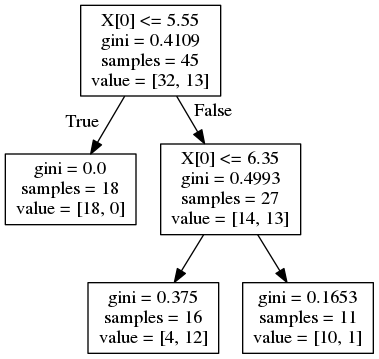

In [54]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)

Xval_unscaled = scaler_train.inverse_transform(Xval)
Xval_unscaled = Xval_unscaled[:results.shape[0]]

clf_data_to_NN = clf.fit(Xval_unscaled, results)
tree.export_graphviz(clf_data_to_NN, out_file='NN_tree.dot')

!dot -Tpng NN_tree.dot -o NN_tree.png

from IPython.display import Image
Image(filename='NN_tree.png') 

In [55]:
#list(zip(iris.data, iris.target))
#np.concatenate((iris.data[validx], iris.target[validx].reshape(len(validx),1)), axis=1)

Estimate of the accuracy with which the decision tree replicates the NN:

In [56]:
# Try a measure of inter-rater agreement such as (weighted Cohen's kappa)

#import ml_metrics
#print(ml_metrics.quadratic_weighted_kappa(clf_data_to_NN.predict(Xval_unscaled), results))

In [57]:
print(np.mean(clf_data_to_NN.predict(Xval_unscaled) == results))

score = cross_val_score(clf_data_to_NN, Xval_unscaled, results, cv=3)

print(score)
print(score.mean())


0.888888888889
[ 0.8125      0.73333333  0.71428571]
0.753373015873


If we want to ensure we have an "explanation" for all predictions we can predict on the data directly from the decision tree trained on the NN.

In [58]:
print("Accuracy of predicting from decision tree trained on NN: {0:.2g}".format(np.mean(clf_data_to_NN.predict(Xval_unscaled) == Yval)))
print("\n(c.f. Accuracy of NN itself: {0:.2g})".format(NN_accuracy))

Accuracy of predicting from decision tree trained on NN: 0.33

(c.f. Accuracy of NN itself: 0.53)


Otherwise, we can predict from the NN itself, in which case we will have no loss of accuracy, but we will only have an "explanation" for the cases where the NN prediction and that of the decision tree prediction match.  
  In this case we would not have an "explanation" for this fraction of samples from the validation set:

In [59]:
print(np.mean(clf_data_to_NN.predict(Xval_unscaled) != results))

0.111111111111


(Note that the cross-validation accuracy of the NN-mimicking decision tree against the NN is perhaps a better estimate for the fraction of samples for which we would have an "explanation", of sorts.)

In general, assuming the NN has better performance on the data set than a shallow decision tree -which is not true in the toy example above- (we assume this as otherwise using a NN would not make sense and one could directly use a more interpretable classifier which outperforms a NN), there is therefore always a trade-off, and one can choose between:  
- Have an explanation for all samples, at the cost of taking a hit in predictive accuracy (i.e. predict from the decision tree trained on the NN), or
- Retain the full accuracy of the NN, but accept a certain fraction of samples for whose prediction we will have no explanation (i.e. predict directly from the NN, using the decision tree's graph to "explain" the classification if the prediction of the NN and the decision tree trained on the NN coincide).

### Tentative thoughts on this approach

As mentioned, this method only makes sense if a NN is the dominant classifier, so in the following we assume this to be the case throughout.  
  
As a thought experiment, consider the limit in which the NN tends to perfect accuracy (or optimises whatever other target metric is being used). In this case, as far as the (now optimised) performance metric is concerned, the NN is indistinguishable from the generative process underlying the data, and the difference between training the decision tree on the NN, or training it directly on the data, vanishes.  
  
Therefore, the accuracy obtained by training the decision tree (of the desired interpretable depth, etc) directly on the data appears to be the upper bound on performance that can be expected from a decision tree trained on the corresponding NN trained on the same data, with the bound being saturated as the NN's performance tends to perfect.
  
Tentative conclusion: **One cannot expect better interpretable performance by training an interpretable classifier on a superior (but uninterpretable) classifier (e.g. a NN), than that obtained by training the interpretable classifier directly on the data**.

If the above reasoning is not flawed (which it may very well be!), then there would be no benefit to training an interpretable classifier on a NN and using the simpler classifier to predict. Using the NN to predict, and using the interpretable classifier only to provide a plausible rationale where their predictions match still makes sense, as long as one is willing to accept the fraction of samples for which the NN and the interpretable classifier differ, and therefore no explanation can be given.